
BACKTEST CONFIGURATION
Dynamic Slippage: Enabled (ATR-based)
Liquidity Constraint: Disabled
Stress Test: Enabled

WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)


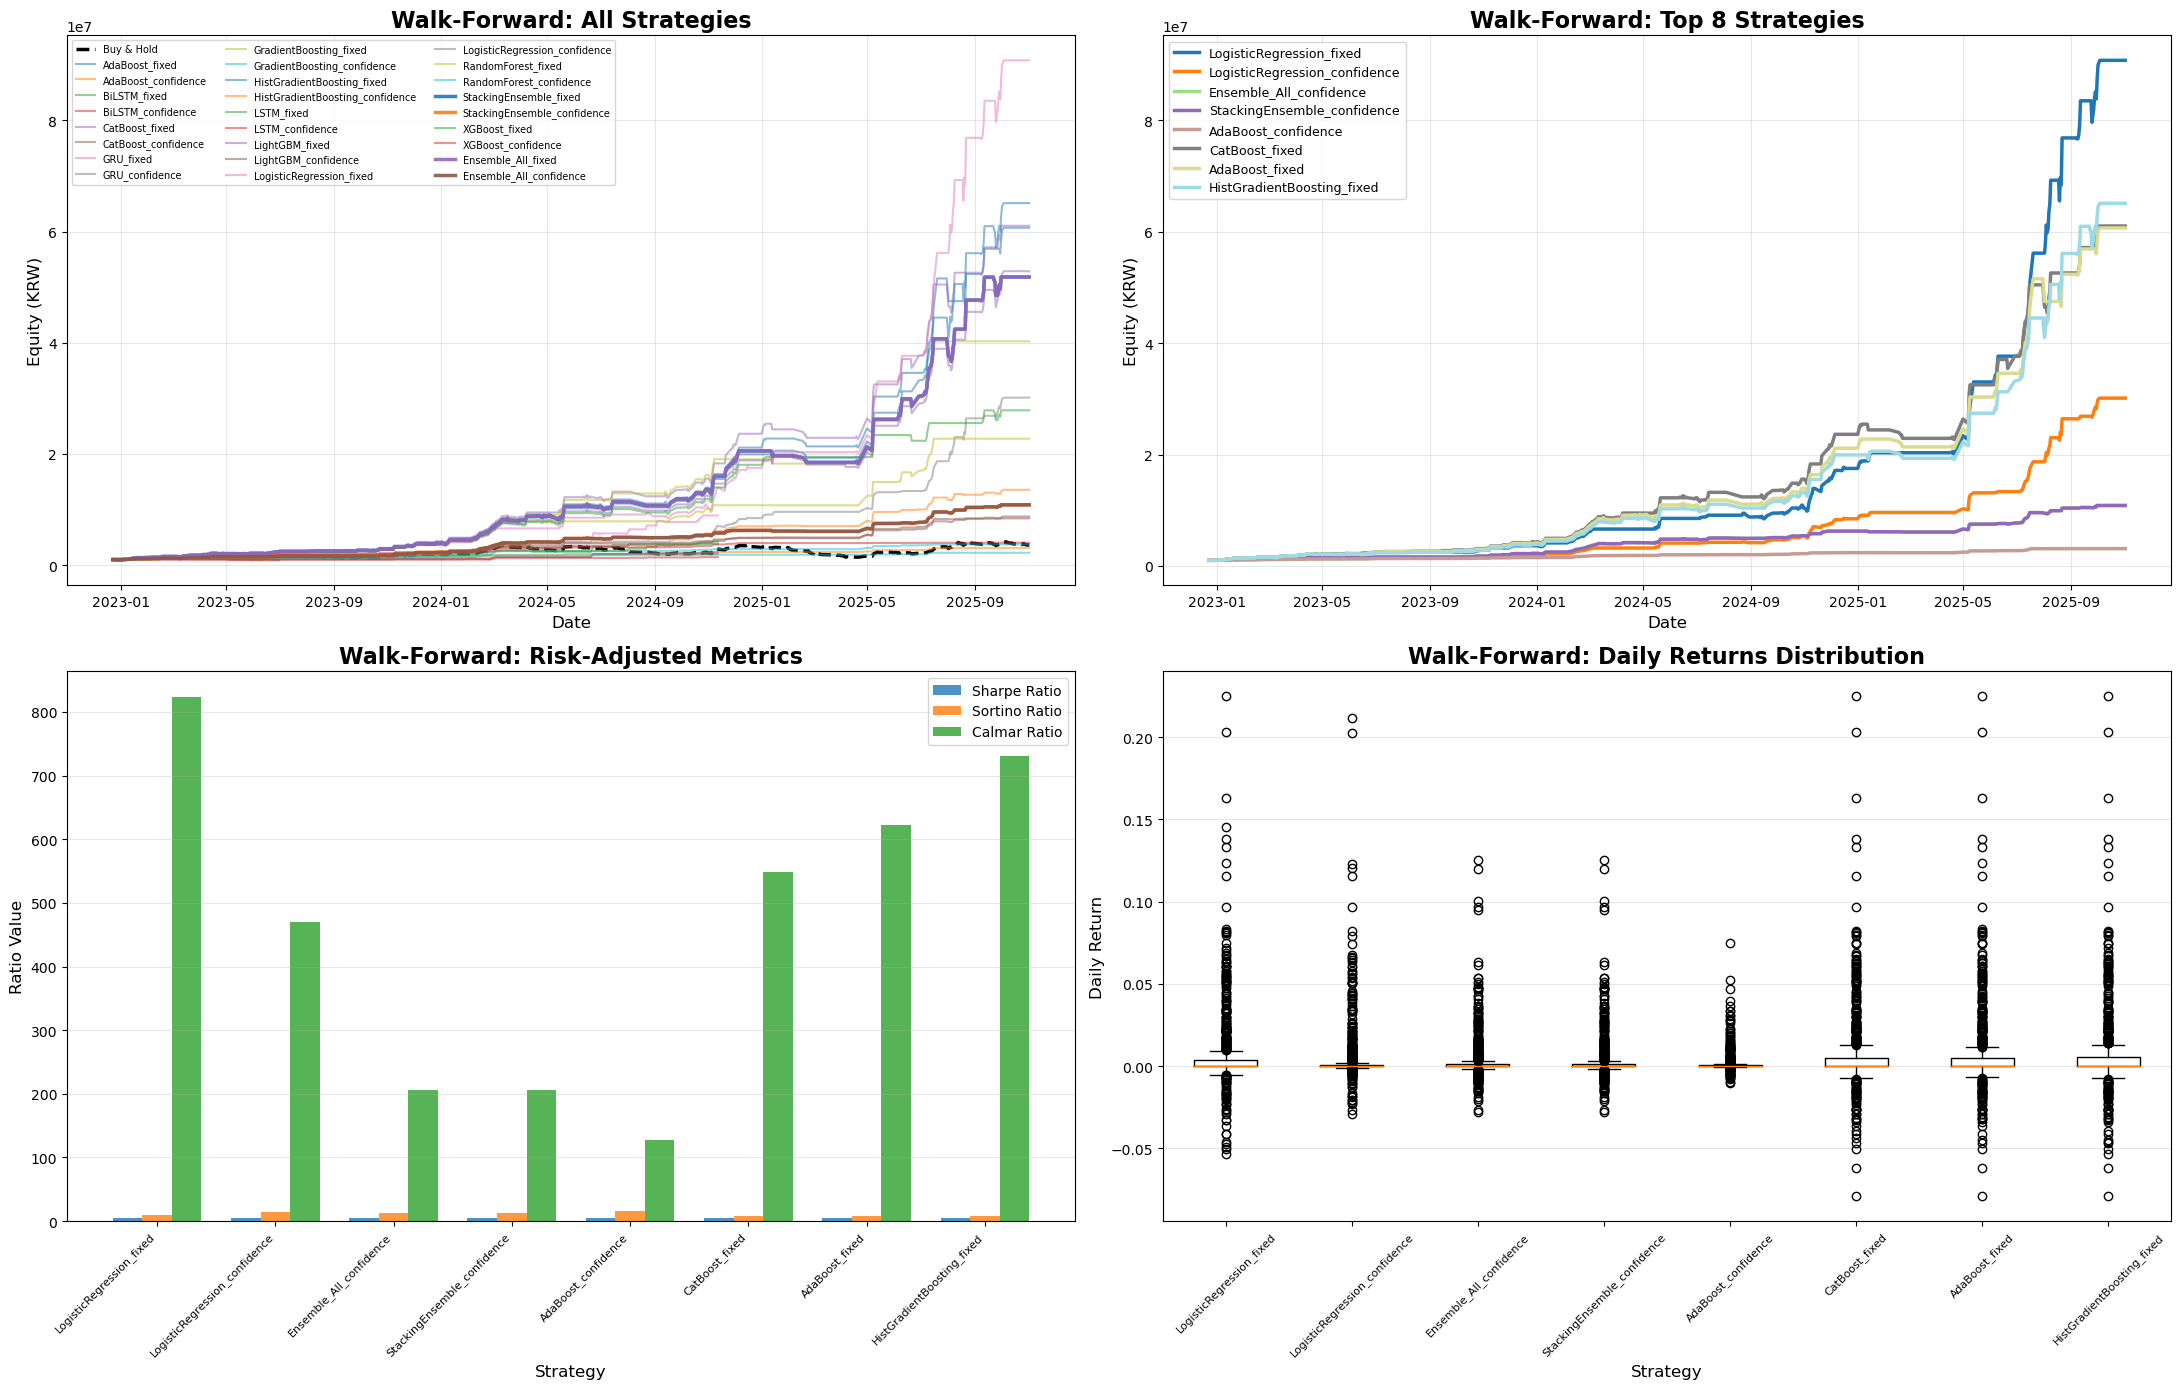

Walk-Forward: PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
LogisticRegression_fixed             8979.79%  -10.91%        5.603         9.590      823.216   69.11%         2.308   0.7067%
LogisticRegression_confidence        2912.93%   -6.19%        5.446        14.056      470.339   69.11%         3.708   0.5338%
Ensemble_All_confidence               984.64%   -4.80%        5.198        12.227      205.240   63.99%         2.804   0.3736%
StackingEnsemble_confidence           984.64%   -4.80%        5.198        12.227      205.240   63.99%         2.804   0.3736%
AdaBoost_confidence                   209.85%   -1.64%        5.191        15.226      127.652   65.49%         3.721   0.1773%
CatBoost_fixed                       6004.08%  -10.94%        5.167         8.393      548.867   65.49%         2.041   0.6444%
AdaBoost_fixed                       5968.61%   -9.60%        5.115   

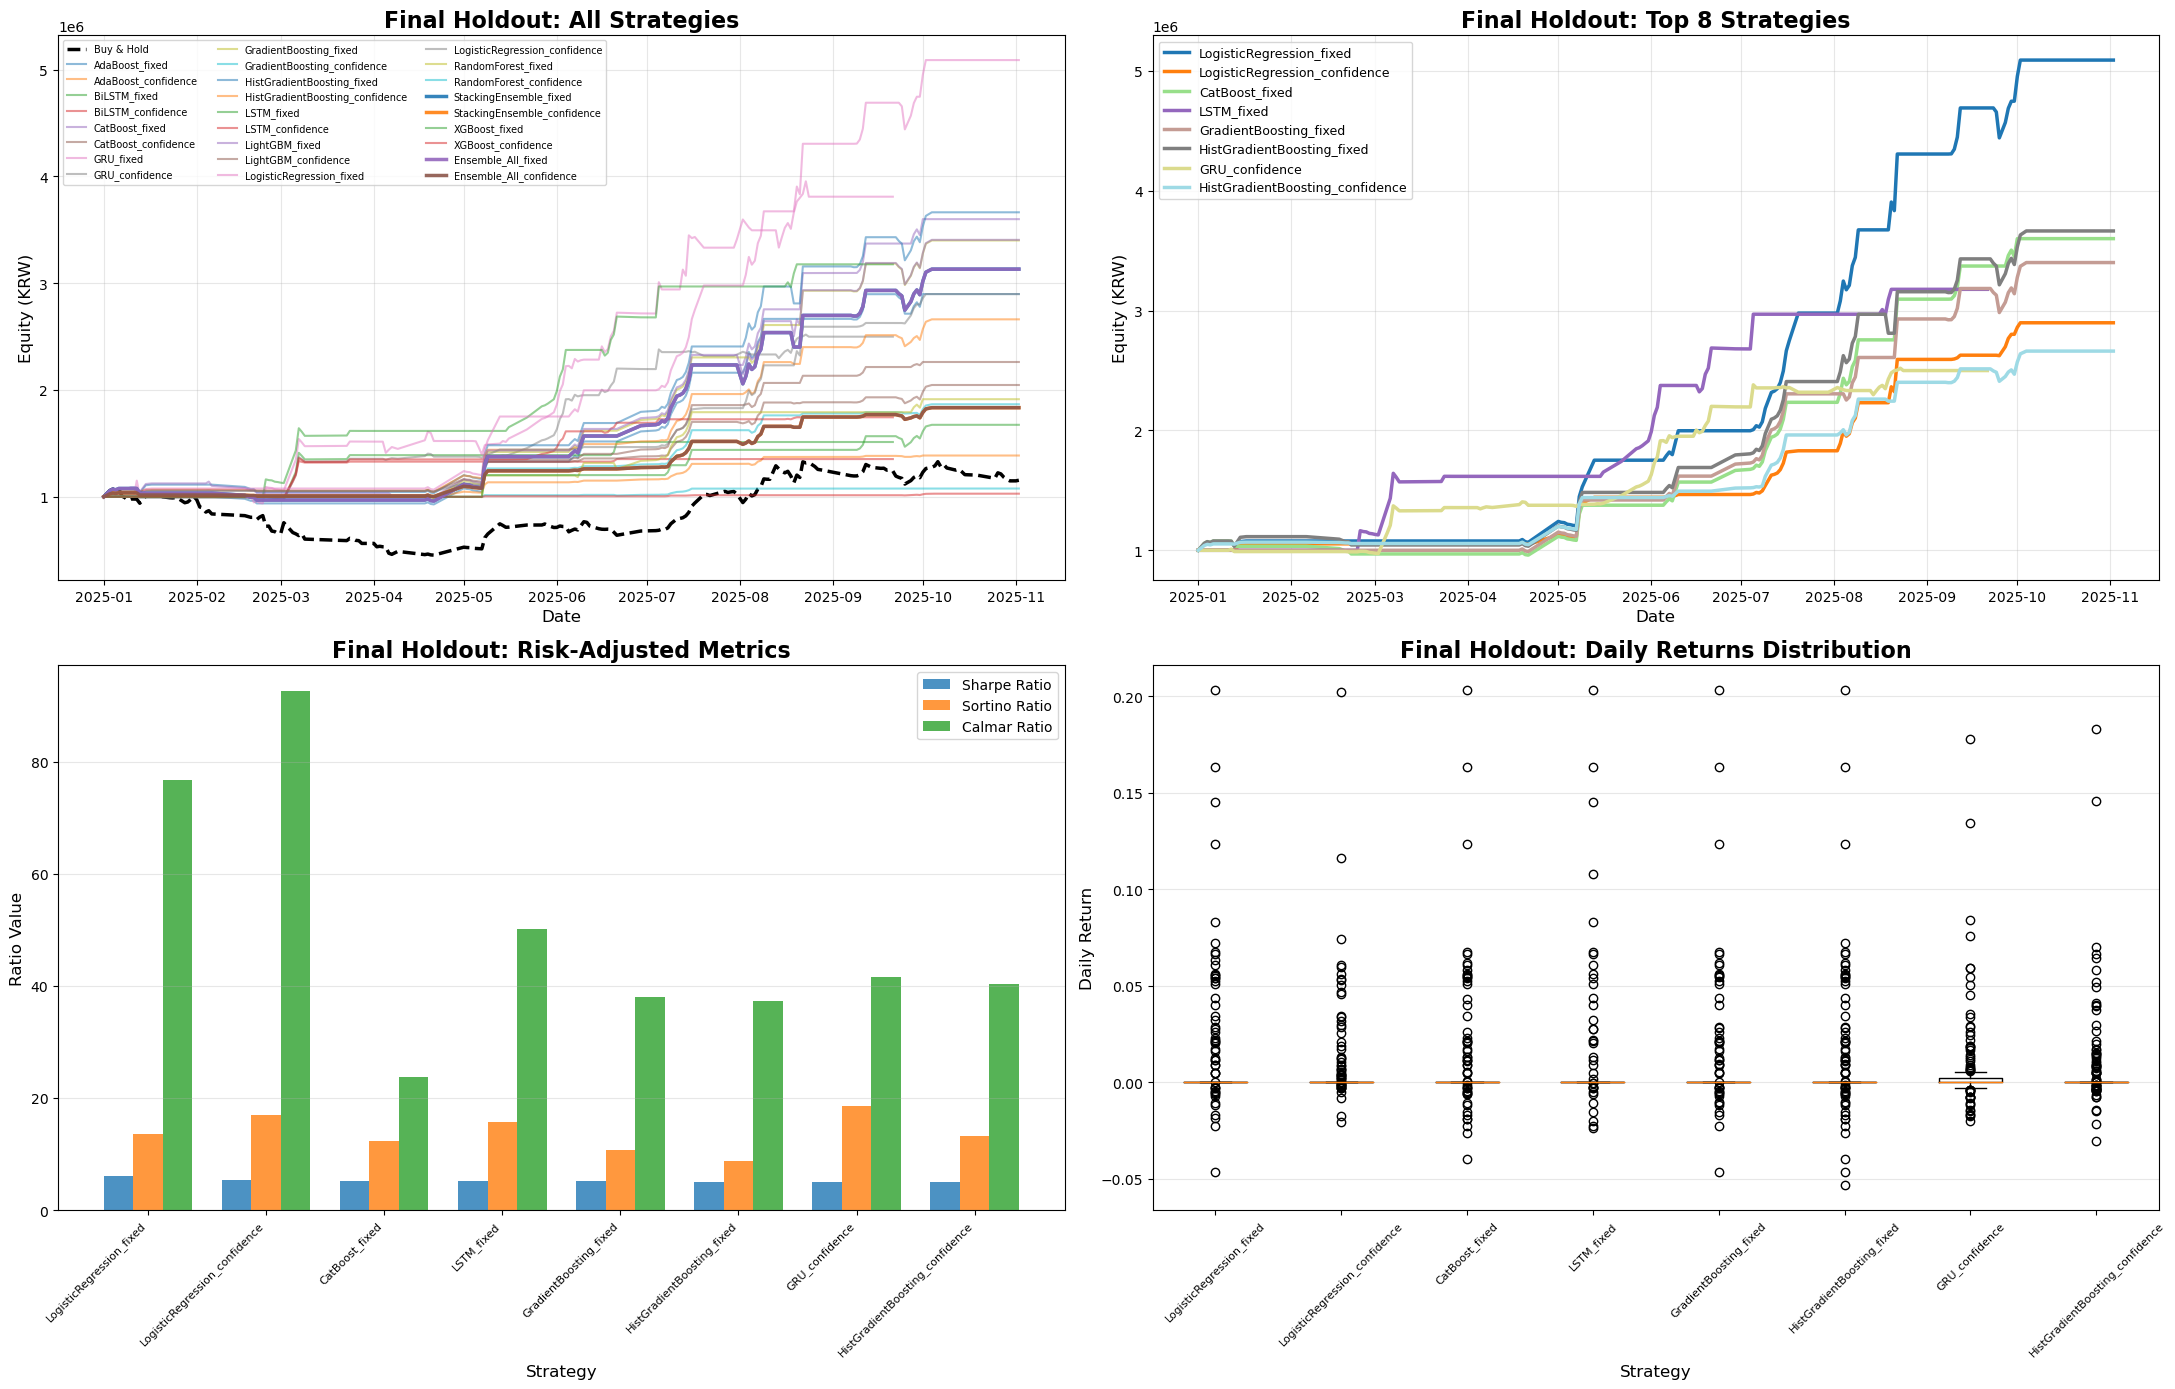

Final Holdout: PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
LogisticRegression_fixed              408.95%   -5.32%        6.075        13.490       76.816   74.07%         3.794   0.8519%
LogisticRegression_confidence         189.80%   -2.05%        5.344        16.901       92.573   74.07%         5.617   0.5571%
CatBoost_fixed                        260.00%  -10.94%        5.242        12.266       23.768   67.86%         3.233   0.6706%
LSTM_fixed                            217.71%   -4.35%        5.145        15.699       50.087   64.86%         5.946   0.7180%
GradientBoosting_fixed                240.03%   -6.30%        5.137        10.769       38.082   68.63%         3.658   0.6408%
HistGradientBoosting_fixed            266.41%   -7.15%        5.059         8.730       37.238   65.15%         2.565   0.6799%
GRU_confidence                        149.93%   -3.61%        5.053  

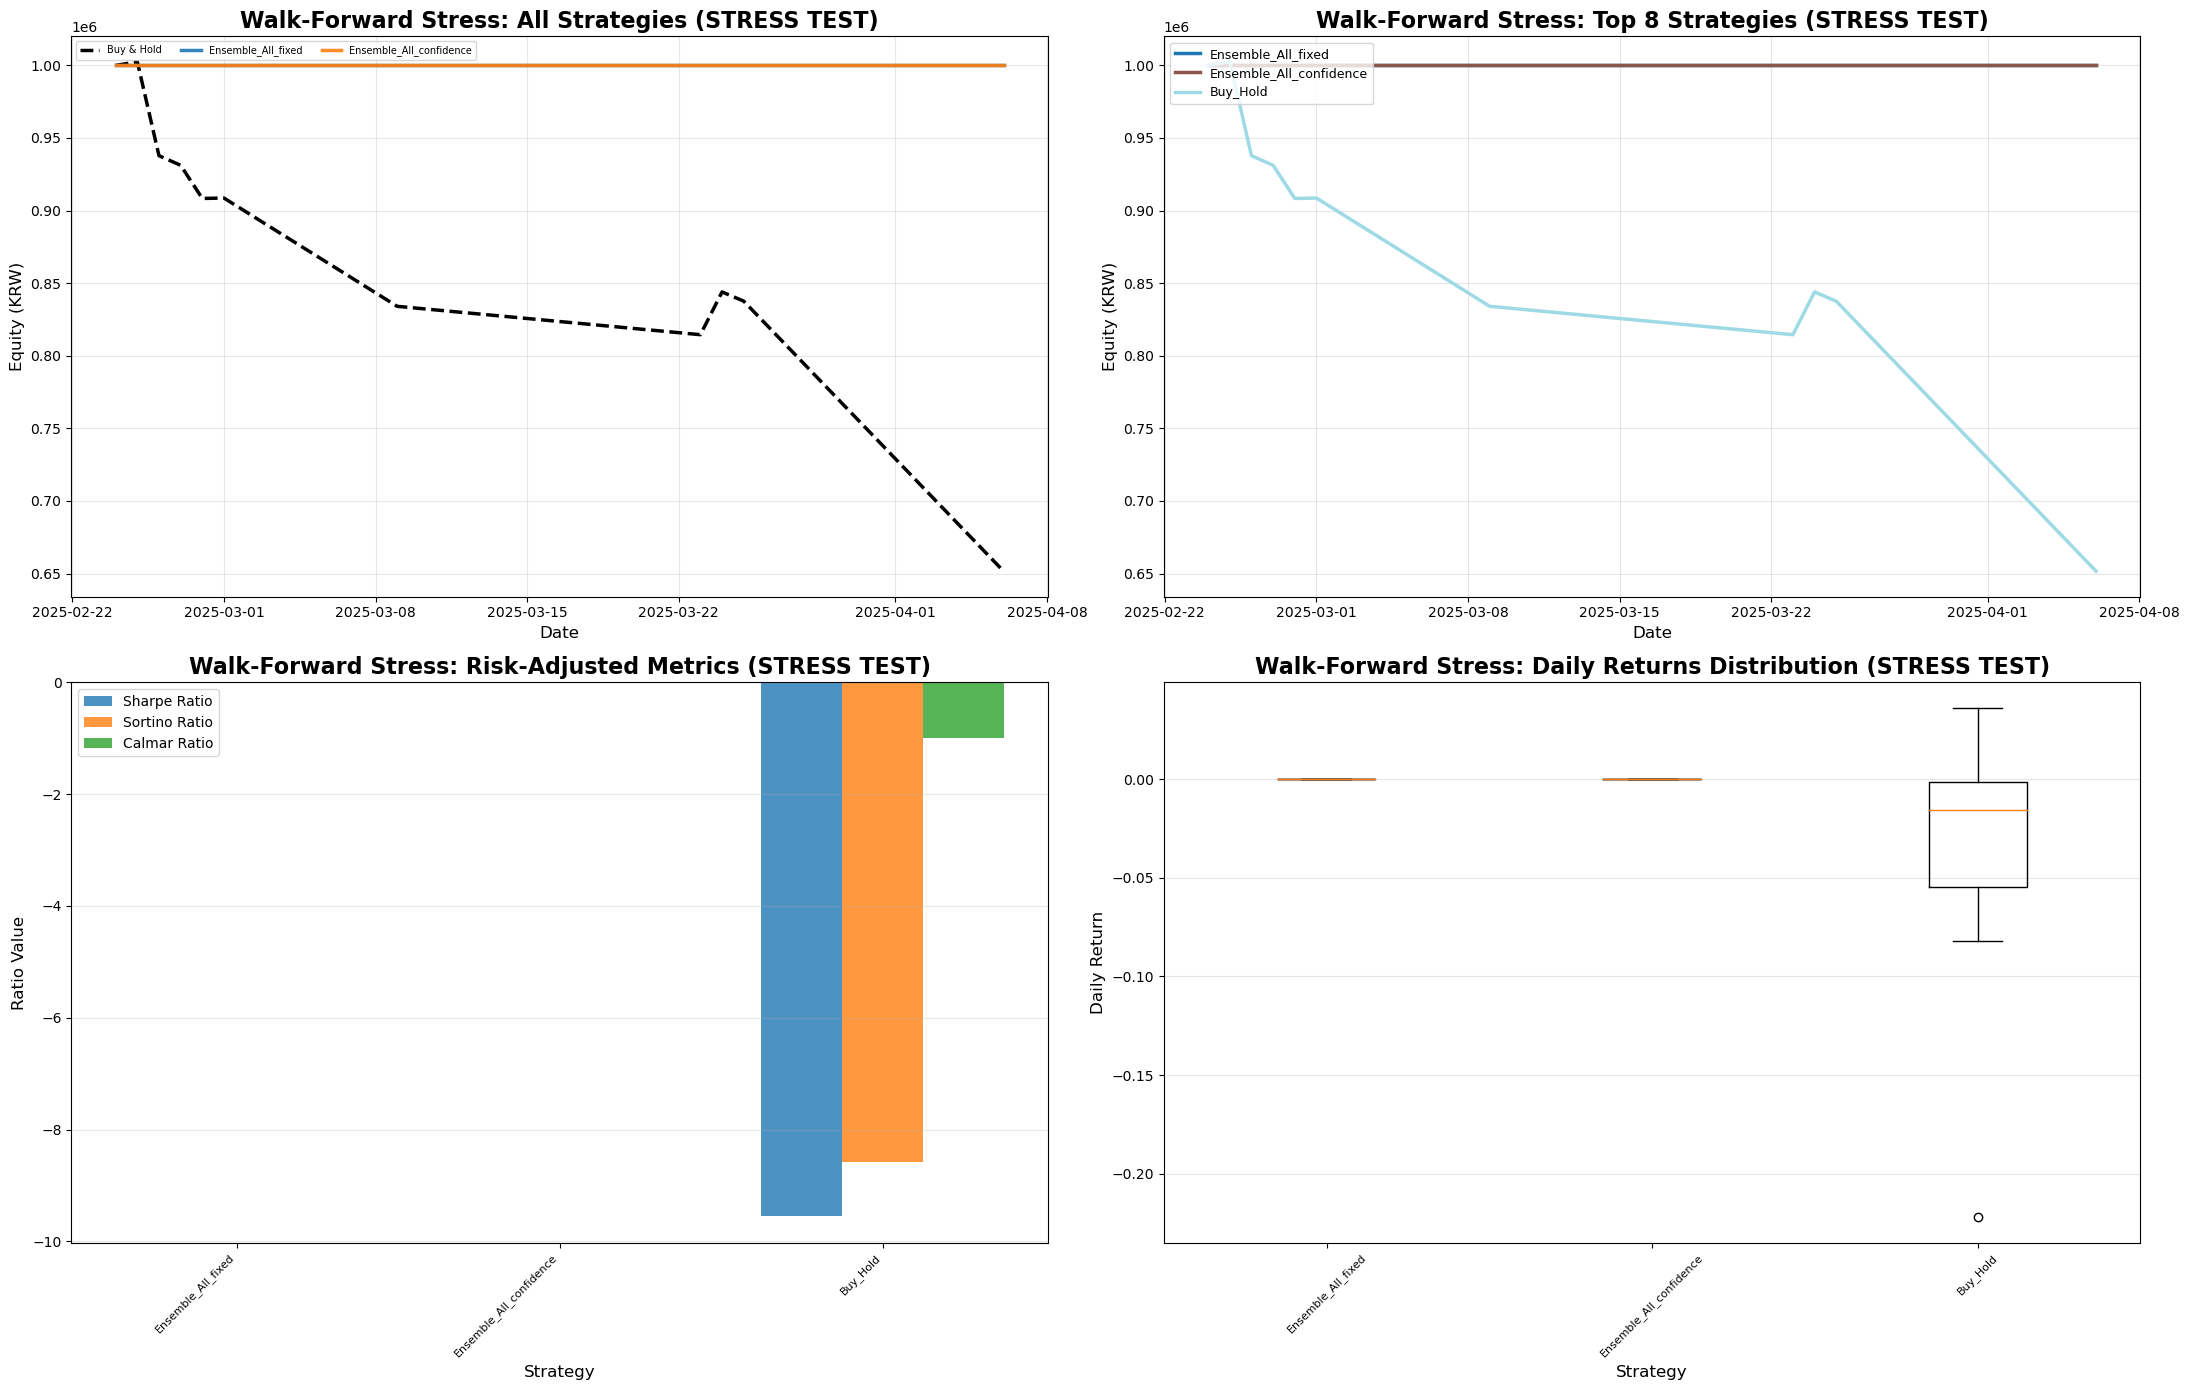

Walk-Forward Stress: PERFORMANCE SUMMARY (STRESS TEST)
                        Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
Ensemble_All_fixed              0.00%    0.00%        0.000         0.000        0.000    0.00%         0.000   0.0000%
Ensemble_All_confidence         0.00%    0.00%        0.000         0.000        0.000    0.00%         0.000   0.0000%
Buy_Hold                      -34.84%  -35.00%       -9.546        -8.586       -0.995   30.00%         0.191  -3.8935%


STRESS TEST: FINAL HOLDOUT HIGH VOLATILITY PERIODS


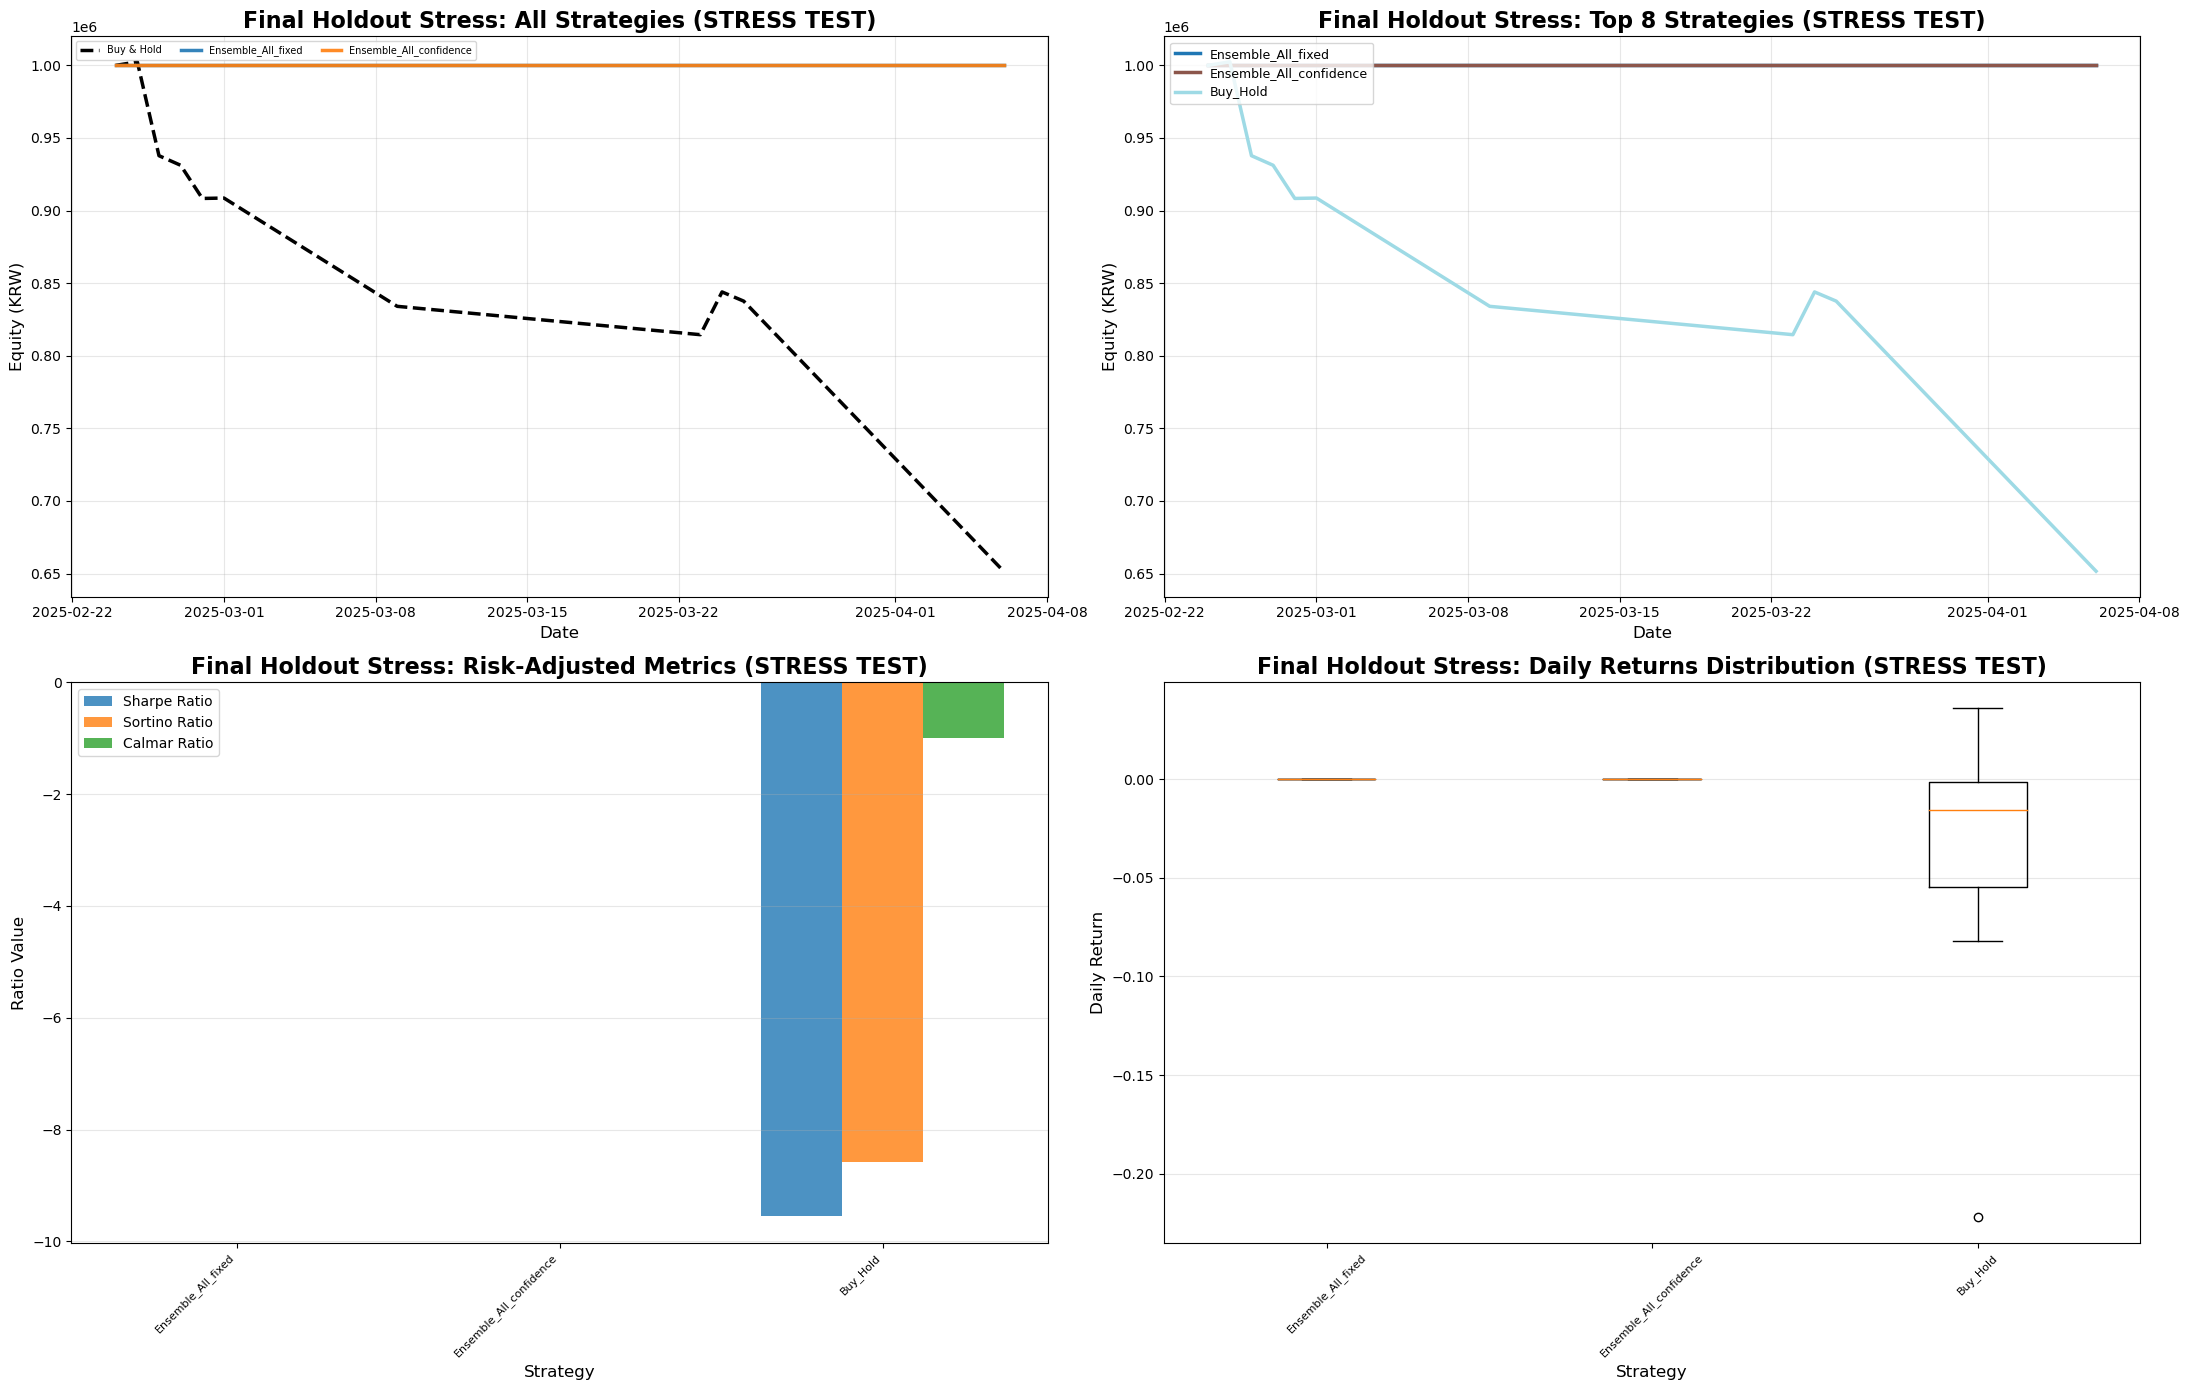

Final Holdout Stress: PERFORMANCE SUMMARY (STRESS TEST)
                        Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
Ensemble_All_fixed              0.00%    0.00%        0.000         0.000        0.000    0.00%         0.000   0.0000%
Ensemble_All_confidence         0.00%    0.00%        0.000         0.000        0.000    0.00%         0.000   0.0000%
Buy_Hold                      -34.84%  -35.00%       -9.546        -8.586       -0.995   30.00%         0.191  -3.8935%


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats

def calculate_performance_metrics(equity_curve, daily_returns):
    total_returns = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    mdd = drawdown.min()
    
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() != 0 else 0
    sortino_ratio = (daily_returns.mean() / daily_returns[daily_returns < 0].std()) * np.sqrt(365) if len(daily_returns[daily_returns < 0]) > 0 and daily_returns[daily_returns < 0].std() != 0 else 0
    calmar_ratio = (total_returns / abs(mdd)) if mdd != 0 else 0
    
    win_rate = len(daily_returns[daily_returns > 0]) / len(daily_returns[daily_returns != 0]) if len(daily_returns[daily_returns != 0]) > 0 else 0
    avg_win = daily_returns[daily_returns > 0].mean() if len(daily_returns[daily_returns > 0]) > 0 else 0
    avg_loss = daily_returns[daily_returns < 0].mean() if len(daily_returns[daily_returns < 0]) > 0 else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    return {
        "Total Returns": total_returns,
        "MDD": mdd,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Win Rate": win_rate,
        "Profit Factor": profit_factor,
        "Avg Trade": daily_returns.mean()
    }

def calculate_kelly_criterion(win_rate, avg_win, avg_loss):
    if avg_loss == 0 or win_rate == 0:
        return 0
    win_loss_ratio = abs(avg_win / avg_loss)
    kelly = (win_rate * win_loss_ratio - (1 - win_rate)) / win_loss_ratio
    return max(0, min(kelly, 0.25))

def calculate_dynamic_slippage(price_df, current_idx, base_slippage=0.0005, atr_window=14):
    if current_idx < atr_window:
        return base_slippage
    
    recent_data = price_df.iloc[max(0, current_idx - atr_window):current_idx + 1]
    
    tr1 = recent_data['ETH_High'] - recent_data['ETH_Low']
    tr2 = abs(recent_data['ETH_High'] - recent_data['ETH_Close'].shift(1))
    tr3 = abs(recent_data['ETH_Low'] - recent_data['ETH_Close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    current_atr = tr.mean()
    
    atr_ratio = current_atr / recent_data['ETH_Close'].iloc[-1]
    
    volume_ratio = 1.0
    if 'ETH_Volume' in recent_data.columns:
        avg_volume = recent_data['ETH_Volume'].mean()
        current_volume = recent_data['ETH_Volume'].iloc[-1]
        volume_ratio = current_volume / avg_volume if avg_volume > 0 else 1.0
    
    atr_multiplier = min(atr_ratio / 0.02, 3.0)
    volume_multiplier = max(0.5, min(2.0 / volume_ratio, 2.0)) if volume_ratio < 1 else 1.0
    
    dynamic_slippage = base_slippage * (1 + atr_multiplier * 0.5 + (volume_multiplier - 1) * 0.3)
    
    return min(dynamic_slippage, base_slippage * 5)

def check_liquidity_constraint(price_df, current_idx, capital_krw, min_volume_ratio=0.01):
    if 'ETH_Volume' in price_df.columns:
        current_price = price_df.loc[current_idx, 'ETH_Close']
        daily_volume_krw = price_df.loc[current_idx, 'ETH_Volume'] * current_price
        
        if capital_krw > daily_volume_krw * min_volume_ratio:
            return False
    
    return True

def dynamic_position_sizing(predictions_df, price_df, lookahead, sizing_method='fixed', 
                           fee_rate=0.0005, base_slippage=0.0005, 
                           use_dynamic_slippage=True, use_liquidity_constraint=False,
                           capital=1_000_000):
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    sim_df = pd.merge(predictions_df, price_df, on='date', how='inner').sort_values(by='date').reset_index(drop=True)
    
    daily_log_returns = pd.Series(0.0, index=sim_df.index)
    position = None
    trade_history = []
    
    for i in range(len(sim_df)):
        current_slippage = calculate_dynamic_slippage(sim_df, i, base_slippage) if use_dynamic_slippage else base_slippage
        
        if position:
            unrealized_return = np.log(sim_df.loc[i, 'ETH_Close'] / sim_df.loc[i-1, 'ETH_Close'])
            daily_log_returns.iloc[i] = unrealized_return * position['size']

        if position:
            exit_price = None
            days_in_trade = i - position['entry_day_index']
            
            if sim_df.loc[i, 'ETH_Low'] <= position['stop_loss']:
                exit_price = position['stop_loss'] * (1 - current_slippage)
            elif sim_df.loc[i, 'ETH_High'] >= position['take_profit']:
                exit_price = position['take_profit'] * (1 - current_slippage)

            
            if not exit_price and days_in_trade >= lookahead:
                if i + 1 < len(sim_df):
                    exit_price = sim_df.loc[i + 1, 'ETH_Open'] * (1 - current_slippage)
                else:
                    exit_price = sim_df.loc[i, 'ETH_Close'] * (1 - current_slippage)

            if exit_price:
                trade_cost = fee_rate
                daily_log_returns.iloc[i] -= trade_cost * position['size']
                
                trade_return = np.log(exit_price / position['entry_price']) - trade_cost
                trade_history.append(trade_return * position['size'])
                
                position = None
        
        if not position and sim_df.loc[i, 'signal'] == 1 and (i + 1 < len(sim_df)):
            if use_liquidity_constraint and not check_liquidity_constraint(sim_df, i, capital):
                continue
            
            trade_cost = fee_rate
            
            if sizing_method == 'fixed':
                position_size = 1.0
            elif sizing_method == 'confidence':
                position_size = sim_df.loc[i, 'confidence']
            elif sizing_method == 'kelly' and len(trade_history) >= 20:
                recent_trades = pd.Series(trade_history[-20:])
                win_rate = len(recent_trades[recent_trades > 0]) / len(recent_trades)
                avg_win = recent_trades[recent_trades > 0].mean() if len(recent_trades[recent_trades > 0]) > 0 else 0
                avg_loss = recent_trades[recent_trades < 0].mean() if len(recent_trades[recent_trades < 0]) > 0 else 0
                position_size = calculate_kelly_criterion(win_rate, avg_win, avg_loss)
            else:
                position_size = 1.0
            
            entry_price = sim_df.loc[i + 1, 'ETH_Open'] * (1 + current_slippage)
            
            daily_log_returns.iloc[i + 1] -= trade_cost * position_size
            position = {
                'entry_price': entry_price,
                'take_profit': sim_df.loc[i, 'take_profit_price'],
                'stop_loss': sim_df.loc[i, 'stop_loss_price'],
                'entry_day_index': i + 1,
                'size': position_size
            }
            
    return daily_log_returns

def identify_stress_periods(price_df, window=30):
    price_df = price_df.copy()
    price_df['returns'] = price_df['ETH_Close'].pct_change()
    price_df['rolling_vol'] = price_df['returns'].rolling(window).std()
    price_df['rolling_dd'] = (price_df['ETH_Close'] / price_df['ETH_Close'].rolling(window).max() - 1)
    
    high_vol_threshold = price_df['rolling_vol'].quantile(0.90)
    high_dd_threshold = price_df['rolling_dd'].quantile(0.10)
    
    stress_periods = price_df[
        (price_df['rolling_vol'] > high_vol_threshold) | 
        (price_df['rolling_dd'] < high_dd_threshold)
    ]['date'].values
    
    return stress_periods

def run_separated_backtest(pred_base_path, master_raw_file_path, confidence_threshold=0.5, 
                           lookahead=5, initial_capital=1_000_000,
                           use_dynamic_slippage=True, use_liquidity_constraint=False,
                           run_stress_test=True):
    
    price_df = pd.read_csv(master_raw_file_path, usecols=['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close'])
    price_df['date'] = pd.to_datetime(price_df['date'])

    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    
    wf_files = [f for f in all_pred_files if 'final_holdout' not in f]
    ho_files = [f for f in all_pred_files if 'final_holdout' in f]
    
    wf_model_files = {}
    for f in wf_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in wf_model_files:
            wf_model_files[model_name] = []
        wf_model_files[model_name].append(f)
    
    ho_model_files = {}
    for f in ho_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        if model_name not in ho_model_files:
            ho_model_files[model_name] = []
        ho_model_files[model_name].append(f)

    stress_periods = identify_stress_periods(price_df) if run_stress_test else []

    def backtest_period(model_files_dict, period_name, stress_only=False):
        all_dates_df = pd.concat([pd.read_csv(f)[['date']] for files in model_files_dict.values() for f in files]).drop_duplicates().sort_values('date')
        all_test_dates = pd.to_datetime(all_dates_df['date'])
        
        if stress_only and len(stress_periods) > 0:
            all_test_dates = all_test_dates[all_test_dates.isin(stress_periods)]
            if len(all_test_dates) == 0:
                print(f"No stress periods found in {period_name}")
                return None
        
        performance_summary = {}
        all_equity_curves = {}
        
        bnh_df = price_df[price_df['date'].isin(all_test_dates)].copy().reset_index(drop=True)
        bnh_df['bnh_return'] = np.log(bnh_df['ETH_Close'] / bnh_df['ETH_Close'].shift(1)).fillna(0)
        bnh_equity = initial_capital * np.exp(bnh_df['bnh_return'].cumsum())
        bnh_metrics = calculate_performance_metrics(bnh_equity, bnh_df['bnh_return'])
        performance_summary['Buy_Hold'] = bnh_metrics
        all_equity_curves['Buy_Hold'] = bnh_equity

        for model_name, files in sorted(model_files_dict.items()):
            preds_df = pd.concat([pd.read_csv(f) for f in files]).drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
            preds_df['signal'] = np.where((preds_df['pred_direction'] == 1) & (preds_df['confidence'] >= confidence_threshold), 1, 0)
            
            if stress_only:
                preds_df = preds_df[preds_df['date'].isin(all_test_dates)]
            
            for sizing_method in ['fixed', 'confidence']:
                strategy_log_returns = dynamic_position_sizing(
                    preds_df, price_df, lookahead, 
                    sizing_method=sizing_method,
                    use_dynamic_slippage=use_dynamic_slippage,
                    use_liquidity_constraint=use_liquidity_constraint,
                    capital=initial_capital
                )
                strategy_equity = initial_capital * np.exp(strategy_log_returns.cumsum())
                
                if len(strategy_equity) > 0:
                    strategy_key = f"{model_name}_{sizing_method}"
                    performance_summary[strategy_key] = calculate_performance_metrics(strategy_equity, strategy_log_returns)
                    all_equity_curves[strategy_key] = strategy_equity

        voting_threshold = 0.3
        ensemble_dates = all_dates_df.copy()
        ensemble_dates['date'] = pd.to_datetime(ensemble_dates['date'])
        
        if stress_only:
            ensemble_dates = ensemble_dates[ensemble_dates['date'].isin(all_test_dates)]
        
        ensemble_dates['vote'] = 0
        
        for model_name, files in model_files_dict.items():
            model_df = pd.concat([pd.read_csv(f) for f in files]).drop_duplicates(subset=['date']).sort_values('date')
            model_df['date'] = pd.to_datetime(model_df['date'])
            model_df['model_signal'] = np.where((model_df['pred_direction'] == 1) & (model_df['confidence'] >= confidence_threshold), 1, 0)
            
            ensemble_dates = pd.merge(ensemble_dates, model_df[['date', 'model_signal', 'take_profit_price', 'stop_loss_price', 'confidence']], 
                                      on='date', how='left', suffixes=('', f'_{model_name}'))
            ensemble_dates['vote'] += ensemble_dates['model_signal'].fillna(0)
            
            if 'take_profit_price' not in ensemble_dates.columns:
                ensemble_dates['take_profit_price'] = model_df['take_profit_price']
                ensemble_dates['stop_loss_price'] = model_df['stop_loss_price']
            
            if 'confidence' not in ensemble_dates.columns or pd.isna(ensemble_dates['confidence']).all():
                ensemble_dates['confidence'] = model_df['confidence']
        
        ensemble_dates['signal'] = np.where(ensemble_dates['vote'] >= len(model_files_dict) * voting_threshold, 1, 0)
        
        for sizing_method in ['fixed', 'confidence']:
            ensemble_log_returns = dynamic_position_sizing(
                ensemble_dates, price_df, lookahead, 
                sizing_method=sizing_method,
                use_dynamic_slippage=use_dynamic_slippage,
                use_liquidity_constraint=use_liquidity_constraint,
                capital=initial_capital
            )
            ensemble_equity = initial_capital * np.exp(ensemble_log_returns.cumsum())
            
            if len(ensemble_equity) > 0:
                strategy_key = f"Ensemble_All_{sizing_method}"
                performance_summary[strategy_key] = calculate_performance_metrics(ensemble_equity, ensemble_log_returns)
                all_equity_curves[strategy_key] = ensemble_equity

        fig, axes = plt.subplots(2, 2, figsize=(22, 14))
        
        axes[0, 0].plot(bnh_df['date'], bnh_equity, label='Buy & Hold', color='black', linestyle='--', linewidth=2.5)
        for strategy_name, equity in all_equity_curves.items():
            if strategy_name != 'Buy_Hold':
                alpha = 0.9 if 'Ensemble' in strategy_name else 0.5
                linewidth = 2.5 if 'Ensemble' in strategy_name else 1.5
                axes[0, 0].plot(bnh_df['date'][:len(equity)], equity, label=strategy_name, alpha=alpha, linewidth=linewidth)
        
        title_suffix = " (STRESS TEST)" if stress_only else ""
        axes[0, 0].set_title(f'{period_name}: All Strategies{title_suffix}', fontsize=16, fontweight='bold')
        axes[0, 0].set_xlabel('Date', fontsize=12)
        axes[0, 0].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 0].legend(loc='upper left', fontsize=7, ncol=3)
        axes[0, 0].grid(True, alpha=0.3)

        summary_df = pd.DataFrame.from_dict(performance_summary, orient='index')
        summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)
        
        top_strategies = summary_df.head(8).index.tolist()
        colors = plt.cm.tab20(np.linspace(0, 1, len(top_strategies)))
        
        for idx, strategy in enumerate(top_strategies):
            if strategy in all_equity_curves:
                dates = bnh_df['date'][:len(all_equity_curves[strategy])]
                axes[0, 1].plot(dates, all_equity_curves[strategy], 
                              label=strategy, linewidth=2.5, color=colors[idx])
        
        axes[0, 1].set_title(f'{period_name}: Top 8 Strategies{title_suffix}', fontsize=16, fontweight='bold')
        axes[0, 1].set_xlabel('Date', fontsize=12)
        axes[0, 1].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 1].legend(loc='upper left', fontsize=9)
        axes[0, 1].grid(True, alpha=0.3)

        metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']
        x = np.arange(len(top_strategies))
        width = 0.25
        
        for idx, metric in enumerate(metrics):
            values = [summary_df.loc[s, metric] if s in summary_df.index else 0 for s in top_strategies]
            axes[1, 0].bar(x + idx * width, values, width, label=metric, alpha=0.8)
        
        axes[1, 0].set_xlabel('Strategy', fontsize=12)
        axes[1, 0].set_ylabel('Ratio Value', fontsize=12)
        axes[1, 0].set_title(f'{period_name}: Risk-Adjusted Metrics{title_suffix}', fontsize=16, fontweight='bold')
        axes[1, 0].set_xticks(x + width)
        axes[1, 0].set_xticklabels(top_strategies, rotation=45, ha='right', fontsize=8)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, axis='y')

        returns_data = []
        strategy_labels = []
        
        for strategy in top_strategies:
            if strategy in all_equity_curves:
                rets = pd.Series(all_equity_curves[strategy]).pct_change().dropna()
                returns_data.append(rets)
                strategy_labels.append(strategy)
        
        axes[1, 1].boxplot(returns_data, labels=strategy_labels)
        axes[1, 1].set_title(f'{period_name}: Daily Returns Distribution{title_suffix}', fontsize=16, fontweight='bold')
        axes[1, 1].set_xlabel('Strategy', fontsize=12)
        axes[1, 1].set_ylabel('Daily Return', fontsize=12)
        axes[1, 1].tick_params(axis='x', rotation=45, labelsize=8)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()

        print("="*120)
        print(f"{period_name}: PERFORMANCE SUMMARY{title_suffix}")
        print("="*120)
        
        display_df = summary_df.copy()
        display_df['Total Returns'] = display_df['Total Returns'].apply(lambda x: f"{x:.2%}")
        display_df['MDD'] = display_df['MDD'].apply(lambda x: f"{x:.2%}")
        display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Win Rate'] = display_df['Win Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Profit Factor'] = display_df['Profit Factor'].apply(lambda x: f"{x:.3f}")
        display_df['Avg Trade'] = display_df['Avg Trade'].apply(lambda x: f"{x:.4%}")
        
        print(display_df.to_string())
        print("="*120)

        return summary_df

    print("\n" + "="*120)
    print(f"BACKTEST CONFIGURATION")
    print("="*120)
    print(f"Dynamic Slippage: {'Enabled (ATR-based)' if use_dynamic_slippage else 'Disabled (Fixed 0.05%)'}")
    print(f"Liquidity Constraint: {'Enabled' if use_liquidity_constraint else 'Disabled'}")
    print(f"Stress Test: {'Enabled' if run_stress_test else 'Disabled'}")
    print("="*120)

    print("\n" + "="*120)
    print("WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)")
    print("="*120)
    wf_summary = backtest_period(wf_model_files, "Walk-Forward")

    print("\n\n" + "="*120)
    print("FINAL HOLDOUT PERIOD (FOLD 8)")
    print("="*120)
    ho_summary = backtest_period(ho_model_files, "Final Holdout")

    if run_stress_test:
        print("\n\n" + "="*120)
        print("STRESS TEST: WALK-FORWARD HIGH VOLATILITY PERIODS")
        print("="*120)
        wf_stress = backtest_period(wf_model_files, "Walk-Forward Stress", stress_only=True)
        
        print("\n\n" + "="*120)
        print("STRESS TEST: FINAL HOLDOUT HIGH VOLATILITY PERIODS")
        print("="*120)
        ho_stress = backtest_period(ho_model_files, "Final Holdout Stress", stress_only=True)

pred_base_path = "../model_results/2025-11-10/fold_results/direction_l5_p2.0_s1.0"
master_raw_file_path = "../model_results/2025-11-09/raw_data/direction/walk_forward/raw_data_all_features.csv"

run_separated_backtest(
    pred_base_path, 
    master_raw_file_path, 
    confidence_threshold=0, 
    lookahead=5,
    use_dynamic_slippage=True,
    use_liquidity_constraint=False,
    run_stress_test=True
)



BACKTEST CONFIGURATION
Dynamic Slippage: Enabled (ATR-based)
Liquidity Constraint: Disabled
Stress Test: Enabled

WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)


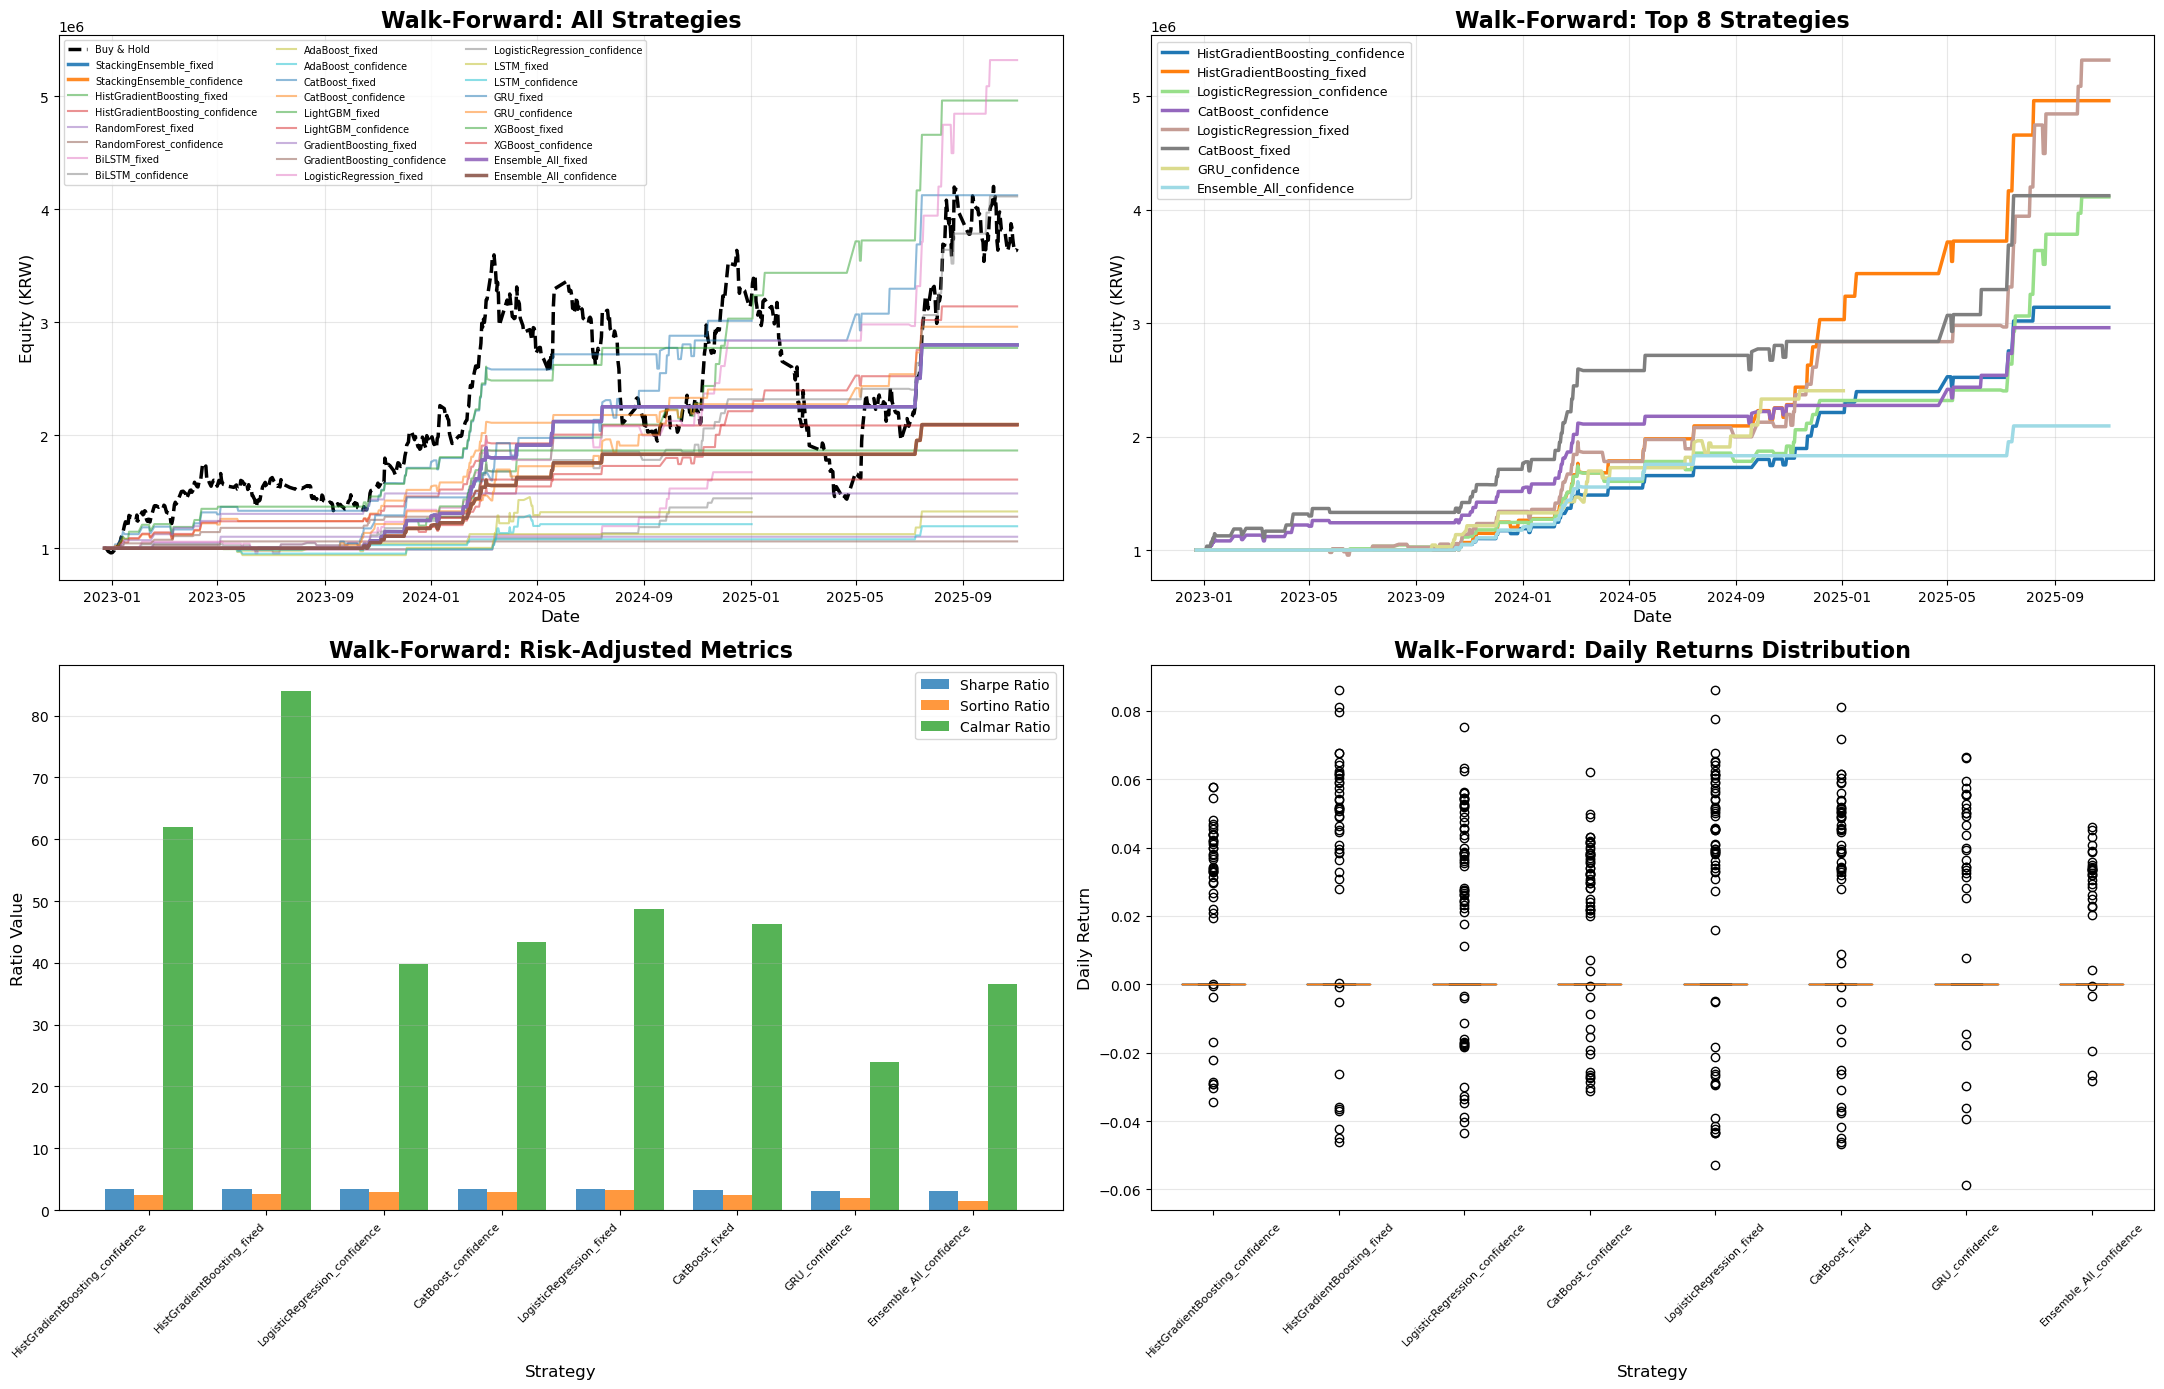

Walk-Forward: PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
HistGradientBoosting_confidence       213.92%   -3.45%        3.444         2.472       61.945   80.43%         1.651   0.1609%
HistGradientBoosting_fixed            396.01%   -4.72%        3.431         2.514       83.926   80.43%         1.632   0.2252%
LogisticRegression_confidence         311.17%   -7.81%        3.394         2.983       39.820   73.02%         1.679   0.1989%
CatBoost_confidence                   195.95%   -4.53%        3.336         2.840       43.295   75.00%         1.619   0.1526%
LogisticRegression_fixed              431.79%   -8.88%        3.334         3.222       48.648   73.02%         1.533   0.2350%
CatBoost_fixed                        312.27%   -6.75%        3.203         2.444       46.281   75.00%         1.468   0.1992%
GRU_confidence                        140.39%   -5.88%        3.124   

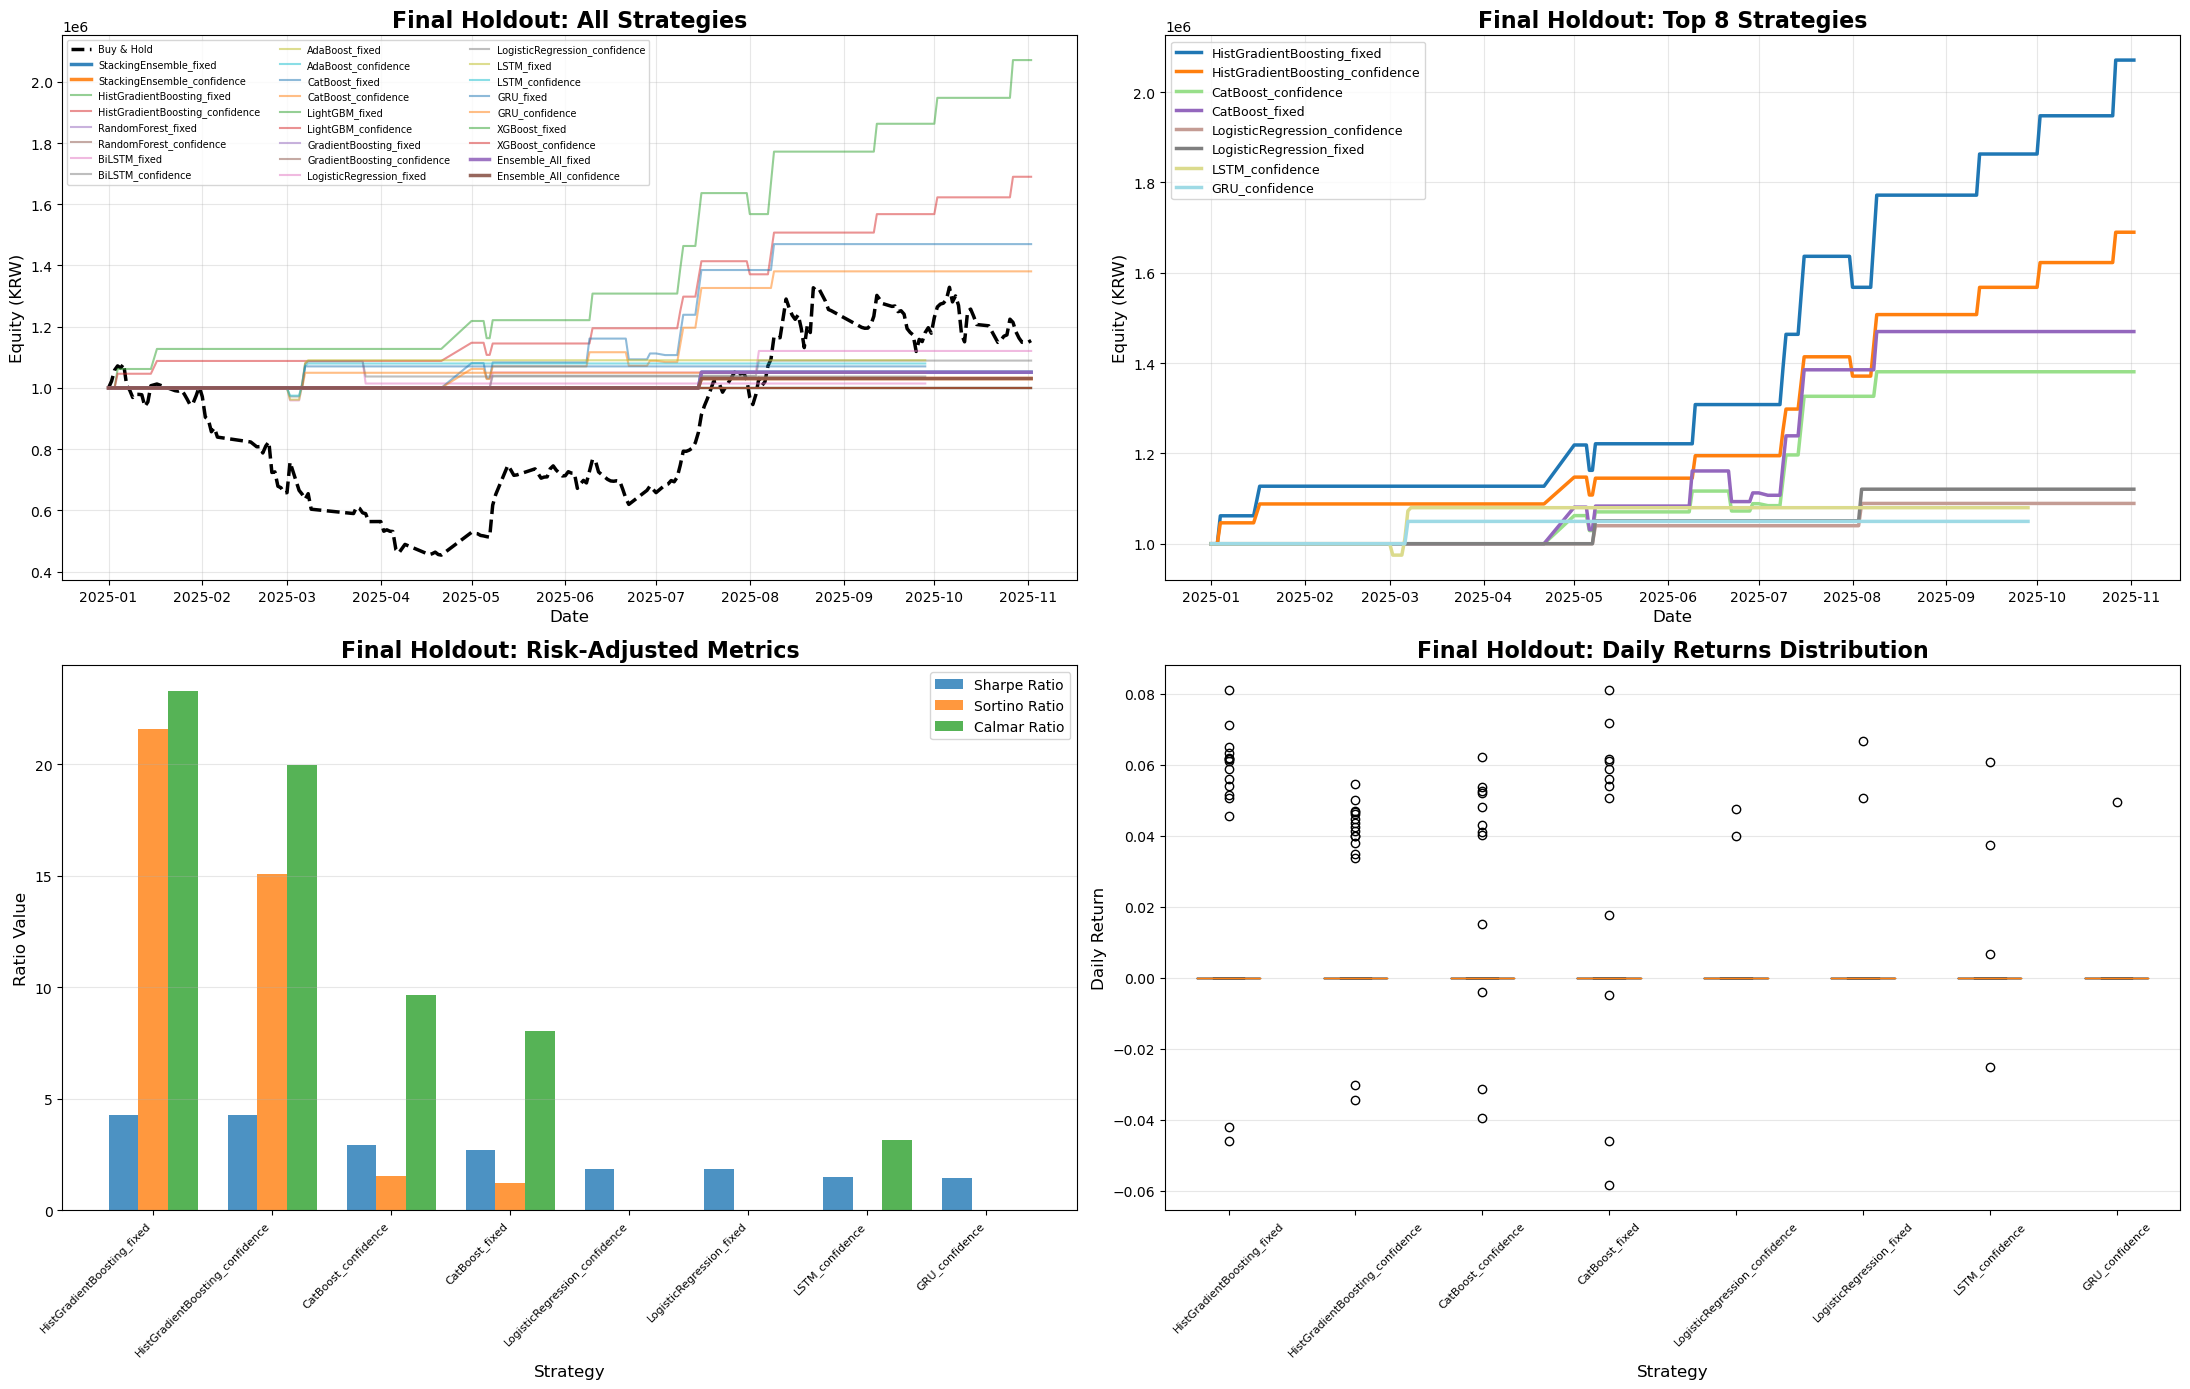

Final Holdout: PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
HistGradientBoosting_fixed            107.11%   -4.61%        4.250        21.581       23.257   87.50%         1.299   0.3434%
HistGradientBoosting_confidence        68.99%   -3.45%        4.245        15.061       19.976   87.50%         1.281   0.2475%
CatBoost_confidence                    38.08%   -3.95%        2.904         1.529        9.630   75.00%         1.748   0.1522%
CatBoost_fixed                         46.99%   -5.84%        2.700         1.197        8.041   75.00%         1.479   0.1817%
LogisticRegression_confidence           8.92%    0.00%        1.853         0.000        0.000  100.00%         0.000   0.0403%
LogisticRegression_fixed               12.08%    0.00%        1.843         0.000        0.000  100.00%         0.000   0.0538%
LSTM_confidence                         7.98%   -2.53%        1.461  

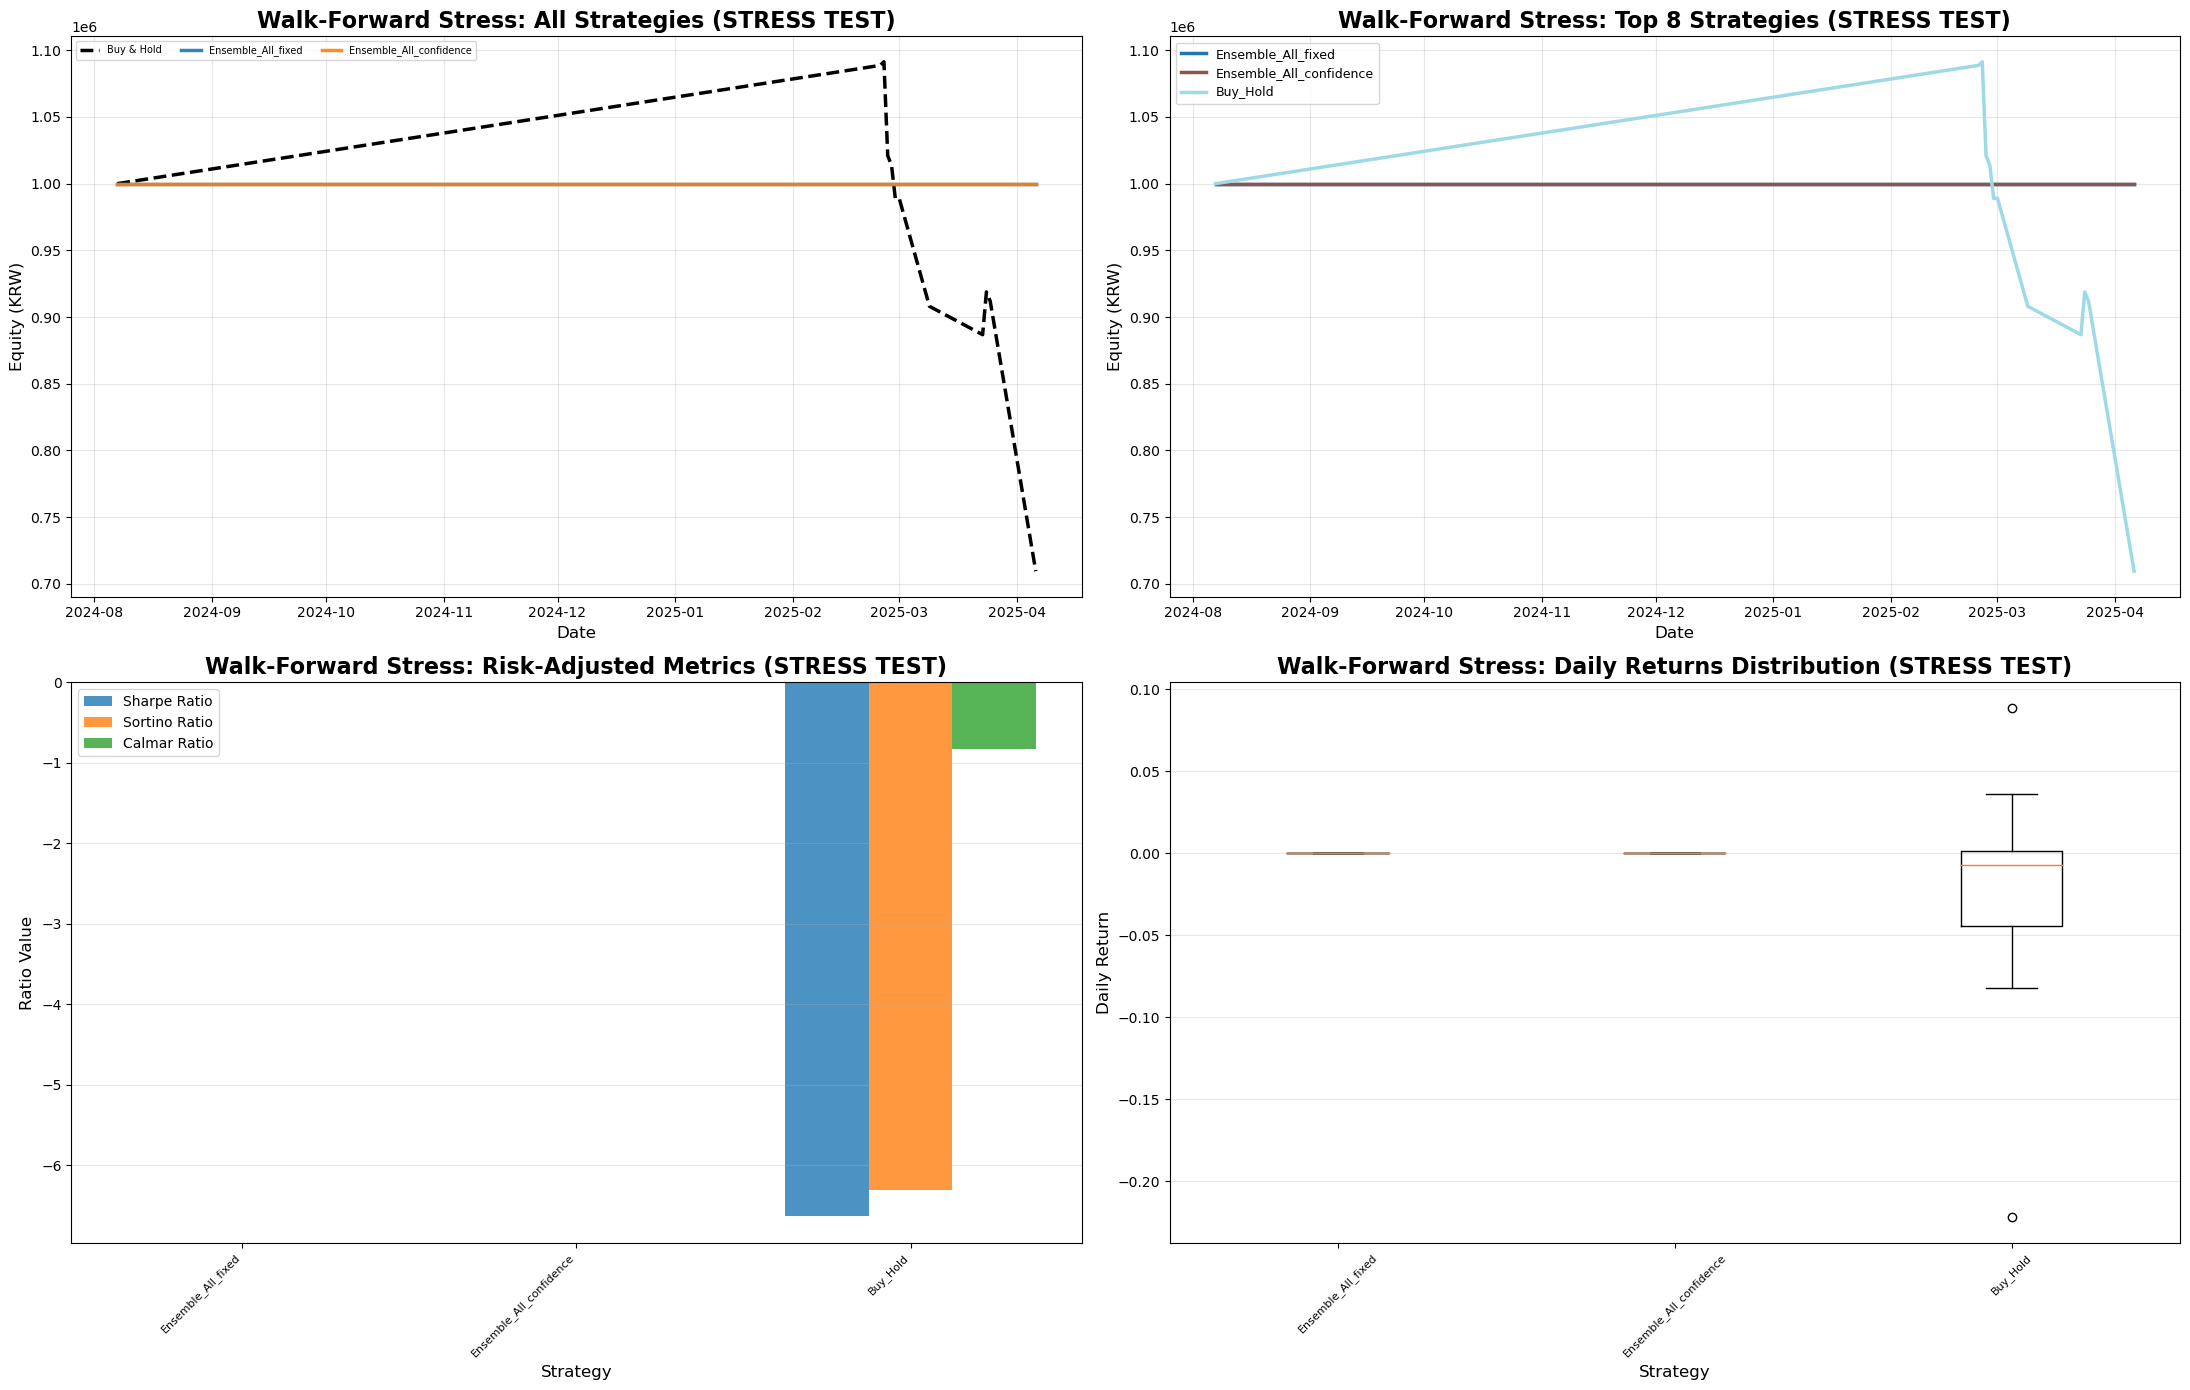

Walk-Forward Stress: PERFORMANCE SUMMARY (STRESS TEST)
                        Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
Ensemble_All_fixed              0.00%    0.00%        0.000         0.000        0.000    0.00%         0.000   0.0000%
Ensemble_All_confidence         0.00%    0.00%        0.000         0.000        0.000    0.00%         0.000   0.0000%
Buy_Hold                      -29.06%  -35.00%       -6.629        -6.309       -0.830   36.36%         0.462  -2.8611%


STRESS TEST: FINAL HOLDOUT HIGH VOLATILITY PERIODS


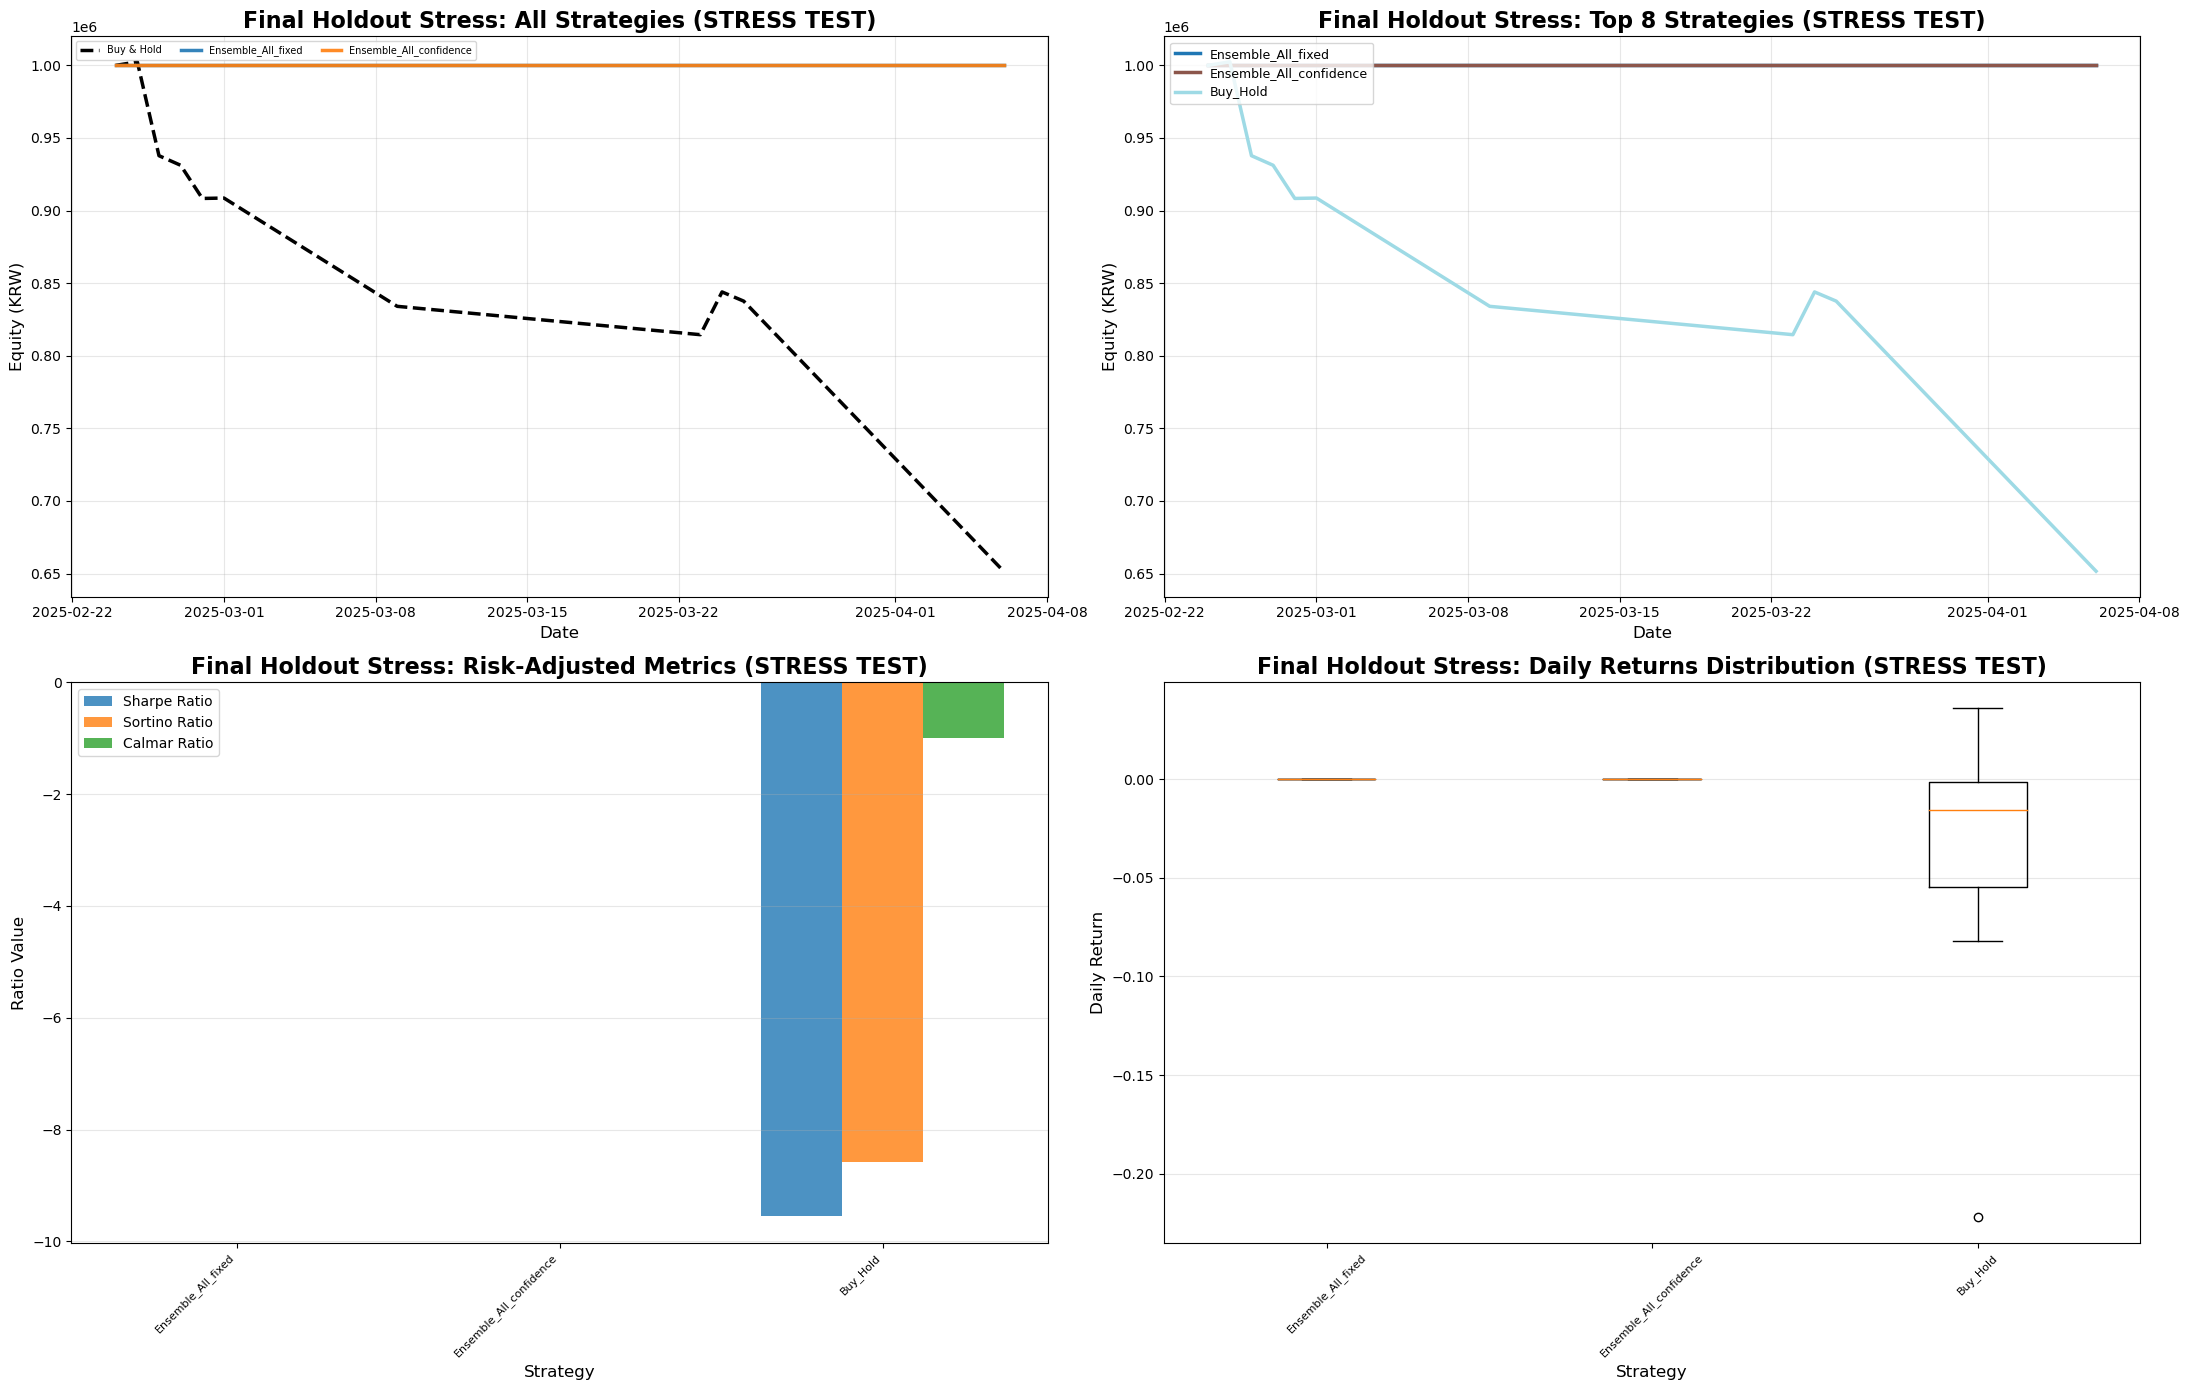

Final Holdout Stress: PERFORMANCE SUMMARY (STRESS TEST)
                        Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Win Rate Profit Factor Avg Trade
Ensemble_All_fixed              0.00%    0.00%        0.000         0.000        0.000    0.00%         0.000   0.0000%
Ensemble_All_confidence         0.00%    0.00%        0.000         0.000        0.000    0.00%         0.000   0.0000%
Buy_Hold                      -34.84%  -35.00%       -9.546        -8.586       -0.995   30.00%         0.191  -3.8935%


In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats

def calculate_performance_metrics(equity_curve, daily_returns):
    total_returns = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    mdd = drawdown.min()
    
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() != 0 else 0
    sortino_ratio = (daily_returns.mean() / daily_returns[daily_returns < 0].std()) * np.sqrt(365) if len(daily_returns[daily_returns < 0]) > 0 and daily_returns[daily_returns < 0].std() != 0 else 0
    calmar_ratio = (total_returns / abs(mdd)) if mdd != 0 else 0
    
    win_rate = len(daily_returns[daily_returns > 0]) / len(daily_returns[daily_returns != 0]) if len(daily_returns[daily_returns != 0]) > 0 else 0
    avg_win = daily_returns[daily_returns > 0].mean() if len(daily_returns[daily_returns > 0]) > 0 else 0
    avg_loss = daily_returns[daily_returns < 0].mean() if len(daily_returns[daily_returns < 0]) > 0 else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    return {
        "Total Returns": total_returns,
        "MDD": mdd,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Win Rate": win_rate,
        "Profit Factor": profit_factor,
        "Avg Trade": daily_returns.mean()
    }

def calculate_kelly_criterion(win_rate, avg_win, avg_loss):
    if avg_loss == 0 or win_rate == 0:
        return 0
    win_loss_ratio = abs(avg_win / avg_loss)
    kelly = (win_rate * win_loss_ratio - (1 - win_rate)) / win_loss_ratio
    return max(0, min(kelly, 0.25))

def calculate_dynamic_slippage(price_df, current_idx, base_slippage=0.0005, atr_window=14):
    if current_idx < atr_window:
        return base_slippage
    
    recent_data = price_df.iloc[max(0, current_idx - atr_window):current_idx + 1]
    
    tr1 = recent_data['ETH_High'] - recent_data['ETH_Low']
    tr2 = abs(recent_data['ETH_High'] - recent_data['ETH_Close'].shift(1))
    tr3 = abs(recent_data['ETH_Low'] - recent_data['ETH_Close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    current_atr = tr.mean()
    
    atr_ratio = current_atr / recent_data['ETH_Close'].iloc[-1]
    
    volume_ratio = 1.0
    if 'ETH_Volume' in recent_data.columns:
        avg_volume = recent_data['ETH_Volume'].mean()
        current_volume = recent_data['ETH_Volume'].iloc[-1]
        volume_ratio = current_volume / avg_volume if avg_volume > 0 else 1.0
    
    atr_multiplier = min(atr_ratio / 0.02, 3.0)
    volume_multiplier = max(0.5, min(2.0 / volume_ratio, 2.0)) if volume_ratio < 1 else 1.0
    
    dynamic_slippage = base_slippage * (1 + atr_multiplier * 0.5 + (volume_multiplier - 1) * 0.3)
    
    return min(dynamic_slippage, base_slippage * 5)

def check_liquidity_constraint(price_df, current_idx, capital_krw, min_volume_ratio=0.01):
    if 'ETH_Volume' in price_df.columns:
        current_price = price_df.loc[current_idx, 'ETH_Close']
        daily_volume_krw = price_df.loc[current_idx, 'ETH_Volume'] * current_price
        
        if capital_krw > daily_volume_krw * min_volume_ratio:
            return False
    
    return True

def dynamic_position_sizing(predictions_df, price_df, lookahead, sizing_method='fixed', 
                           fee_rate=0.0005, base_slippage=0.0005, 
                           use_dynamic_slippage=True, use_liquidity_constraint=False,
                           capital=1_000_000):
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    sim_df = pd.merge(predictions_df, price_df, on='date', how='inner').sort_values(by='date').reset_index(drop=True)
    
    daily_log_returns = pd.Series(0.0, index=sim_df.index)
    position = None
    trade_history = []
    
    for i in range(len(sim_df)):
        current_slippage = calculate_dynamic_slippage(sim_df, i, base_slippage) if use_dynamic_slippage else base_slippage
        
        if position:
            days_in_trade = i - position['entry_day_index']
            exit_price = None
            exit_reason = None
            
            if sim_df.loc[i, 'ETH_Low'] <= position['stop_loss']:
                exit_price = position['stop_loss']
                exit_reason = 'stop_loss'
            elif sim_df.loc[i, 'ETH_High'] >= position['take_profit']:
                exit_price = position['take_profit']
                exit_reason = 'take_profit'
            elif days_in_trade >= lookahead:
                if i + 1 < len(sim_df):
                    exit_price = sim_df.loc[i + 1, 'ETH_Open']
                else:
                    exit_price = sim_df.loc[i, 'ETH_Close']
                exit_reason = 'time_exit'

            if exit_price:
                total_cost = current_slippage + fee_rate
                actual_exit_price = exit_price * (1 - total_cost)
                
                trade_return = np.log(actual_exit_price / position['entry_price'])
                daily_log_returns.iloc[i] = trade_return * position['size']
                trade_history.append(trade_return * position['size'])
                
                position = None
        
        if not position and sim_df.loc[i, 'signal'] == 1 and (i + 1 < len(sim_df)):
            if use_liquidity_constraint and not check_liquidity_constraint(sim_df, i, capital):
                continue
            
            if sizing_method == 'fixed':
                position_size = 1.0
            elif sizing_method == 'confidence':
                position_size = sim_df.loc[i, 'confidence']
            elif sizing_method == 'kelly' and len(trade_history) >= 20:
                recent_trades = pd.Series(trade_history[-20:])
                win_rate = len(recent_trades[recent_trades > 0]) / len(recent_trades)
                avg_win = recent_trades[recent_trades > 0].mean() if len(recent_trades[recent_trades > 0]) > 0 else 0
                avg_loss = recent_trades[recent_trades < 0].mean() if len(recent_trades[recent_trades < 0]) > 0 else 0
                position_size = calculate_kelly_criterion(win_rate, avg_win, avg_loss)
            else:
                position_size = 1.0
            
            entry_slippage = calculate_dynamic_slippage(sim_df, i + 1, base_slippage) if use_dynamic_slippage else base_slippage
            total_entry_cost = entry_slippage + fee_rate
            entry_price = sim_df.loc[i + 1, 'ETH_Open'] * (1 + total_entry_cost)
            
            position = {
                'entry_price': entry_price,
                'take_profit': sim_df.loc[i, 'take_profit_price'],
                'stop_loss': sim_df.loc[i, 'stop_loss_price'],
                'entry_day_index': i + 1,
                'size': position_size
            }
            
    return daily_log_returns

def identify_stress_periods(price_df, window=30):
    price_df = price_df.copy()
    price_df['returns'] = price_df['ETH_Close'].pct_change()
    price_df['rolling_vol'] = price_df['returns'].rolling(window).std()
    price_df['rolling_dd'] = (price_df['ETH_Close'] / price_df['ETH_Close'].rolling(window).max() - 1)
    
    high_vol_threshold = price_df['rolling_vol'].quantile(0.90)
    high_dd_threshold = price_df['rolling_dd'].quantile(0.10)
    
    stress_periods = price_df[
        (price_df['rolling_vol'] > high_vol_threshold) | 
        (price_df['rolling_dd'] < high_dd_threshold)
    ]['date'].values
    
    return stress_periods

def run_separated_backtest(pred_base_path, master_raw_file_path, confidence_threshold=0.5, 
                           lookahead=5, initial_capital=1_000_000,
                           use_dynamic_slippage=True, use_liquidity_constraint=False,
                           run_stress_test=True):
    
    price_df = pd.read_csv(master_raw_file_path, usecols=['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close'])
    price_df['date'] = pd.to_datetime(price_df['date'])

    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    
    wf_files = [f for f in all_pred_files if 'final_holdout' not in f]
    ho_files = [f for f in all_pred_files if 'final_holdout' in f]
    
    wf_model_files = {}
    for f in wf_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        fold_name = os.path.basename(os.path.dirname(f))
        if model_name not in wf_model_files:
            wf_model_files[model_name] = {}
        if fold_name not in wf_model_files[model_name]:
            wf_model_files[model_name][fold_name] = []
        wf_model_files[model_name][fold_name].append(f)
    
    ho_model_files = {}
    for f in ho_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        fold_name = os.path.basename(os.path.dirname(f))
        if model_name not in ho_model_files:
            ho_model_files[model_name] = {}
        if fold_name not in ho_model_files[model_name]:
            ho_model_files[model_name][fold_name] = []
        ho_model_files[model_name][fold_name].append(f)

    stress_periods = identify_stress_periods(price_df) if run_stress_test else []

    def backtest_per_fold(model_files_dict, period_name):
        all_folds = sorted(set([fold for files_by_fold in model_files_dict.values() for fold in files_by_fold.keys()]))
        
        fold_performance = {}
        
        for fold in all_folds:
            fold_results = {}
            
            fold_files = []
            for model_name, files_by_fold in model_files_dict.items():
                if fold in files_by_fold:
                    fold_files.extend(files_by_fold[fold])
            
            if not fold_files:
                continue
            
            all_dates_df = pd.concat([pd.read_csv(f)[['date']] for f in fold_files]).drop_duplicates().sort_values('date')
            all_test_dates = pd.to_datetime(all_dates_df['date'])
            
            bnh_df = price_df[price_df['date'].isin(all_test_dates)].copy().reset_index(drop=True)
            if len(bnh_df) == 0:
                continue
            
            bnh_df['bnh_return'] = np.log(bnh_df['ETH_Close'] / bnh_df['ETH_Close'].shift(1)).fillna(0)
            bnh_equity = initial_capital * np.exp(bnh_df['bnh_return'].cumsum())
            bnh_metrics = calculate_performance_metrics(bnh_equity, bnh_df['bnh_return'])
            fold_results['Buy_Hold'] = bnh_metrics
            
            for model_name in model_files_dict.keys():
                if fold not in model_files_dict[model_name]:
                    continue
                
                files = model_files_dict[model_name][fold]
                preds_df = pd.concat([pd.read_csv(f) for f in files]).drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
                preds_df['signal'] = np.where((preds_df['pred_direction'] == 1) & (preds_df['confidence'] >= confidence_threshold), 1, 0)
                
                for sizing_method in ['fixed', 'confidence']:
                    strategy_log_returns = dynamic_position_sizing(
                        preds_df, price_df, lookahead, 
                        sizing_method=sizing_method,
                        use_dynamic_slippage=use_dynamic_slippage,
                        use_liquidity_constraint=use_liquidity_constraint,
                        capital=initial_capital
                    )
                    strategy_equity = initial_capital * np.exp(strategy_log_returns.cumsum())
                    
                    if len(strategy_equity) > 0:
                        strategy_key = f"{model_name}_{sizing_method}"
                        fold_results[strategy_key] = calculate_performance_metrics(strategy_equity, strategy_log_returns)
            
            fold_performance[fold] = fold_results
        
        print("="*120)
        print(f"{period_name}: PER-FOLD PERFORMANCE COMPARISON")
        print("="*120)
        
        for fold in sorted(fold_performance.keys()):
            print(f"\n{fold}:")
            print("-"*120)
            
            fold_df = pd.DataFrame.from_dict(fold_performance[fold], orient='index')
            fold_df = fold_df.sort_values('Sharpe Ratio', ascending=False)
            
            display_df = fold_df.copy()
            display_df['Total Returns'] = display_df['Total Returns'].apply(lambda x: f"{x:.2%}")
            display_df['MDD'] = display_df['MDD'].apply(lambda x: f"{x:.2%}")
            display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
            display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
            display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
            display_df['Win Rate'] = display_df['Win Rate'].apply(lambda x: f"{x:.2%}")
            display_df['Profit Factor'] = display_df['Profit Factor'].apply(lambda x: f"{x:.3f}")
            display_df['Avg Trade'] = display_df['Avg Trade'].apply(lambda x: f"{x:.4%}")
            
            print(display_df.to_string())
        
        print("="*120)

    def backtest_period(model_files_dict, period_name, stress_only=False):
        all_files = [f for files_by_fold in model_files_dict.values() for files in files_by_fold.values() for f in files]
        all_dates_df = pd.concat([pd.read_csv(f)[['date']] for f in all_files]).drop_duplicates().sort_values('date')
        all_test_dates = pd.to_datetime(all_dates_df['date'])
        
        if stress_only and len(stress_periods) > 0:
            all_test_dates = all_test_dates[all_test_dates.isin(stress_periods)]
            if len(all_test_dates) == 0:
                print(f"No stress periods found in {period_name}")
                return None
        
        performance_summary = {}
        all_equity_curves = {}
        
        bnh_df = price_df[price_df['date'].isin(all_test_dates)].copy().reset_index(drop=True)
        bnh_df['bnh_return'] = np.log(bnh_df['ETH_Close'] / bnh_df['ETH_Close'].shift(1)).fillna(0)
        bnh_equity = initial_capital * np.exp(bnh_df['bnh_return'].cumsum())
        bnh_metrics = calculate_performance_metrics(bnh_equity, bnh_df['bnh_return'])
        performance_summary['Buy_Hold'] = bnh_metrics
        all_equity_curves['Buy_Hold'] = bnh_equity

        for model_name in model_files_dict.keys():
            all_model_files = [f for files in model_files_dict[model_name].values() for f in files]
            preds_df = pd.concat([pd.read_csv(f) for f in all_model_files]).drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
            preds_df['signal'] = np.where((preds_df['pred_direction'] == 1) & (preds_df['confidence'] >= confidence_threshold), 1, 0)
            
            if stress_only:
                preds_df = preds_df[preds_df['date'].isin(all_test_dates)]
            
            for sizing_method in ['fixed', 'confidence']:
                strategy_log_returns = dynamic_position_sizing(
                    preds_df, price_df, lookahead, 
                    sizing_method=sizing_method,
                    use_dynamic_slippage=use_dynamic_slippage,
                    use_liquidity_constraint=use_liquidity_constraint,
                    capital=initial_capital
                )
                strategy_equity = initial_capital * np.exp(strategy_log_returns.cumsum())
                
                if len(strategy_equity) > 0:
                    strategy_key = f"{model_name}_{sizing_method}"
                    performance_summary[strategy_key] = calculate_performance_metrics(strategy_equity, strategy_log_returns)
                    all_equity_curves[strategy_key] = strategy_equity

        voting_threshold = 0.3
        ensemble_dates = all_dates_df.copy()
        ensemble_dates['date'] = pd.to_datetime(ensemble_dates['date'])
        
        if stress_only:
            ensemble_dates = ensemble_dates[ensemble_dates['date'].isin(all_test_dates)]
        
        ensemble_dates['vote'] = 0
        
        for model_name in model_files_dict.keys():
            all_model_files = [f for files in model_files_dict[model_name].values() for f in files]
            model_df = pd.concat([pd.read_csv(f) for f in all_model_files]).drop_duplicates(subset=['date']).sort_values('date')
            model_df['date'] = pd.to_datetime(model_df['date'])
            model_df['model_signal'] = np.where((model_df['pred_direction'] == 1) & (model_df['confidence'] >= confidence_threshold), 1, 0)
            
            ensemble_dates = pd.merge(ensemble_dates, model_df[['date', 'model_signal', 'take_profit_price', 'stop_loss_price', 'confidence']], 
                                      on='date', how='left', suffixes=('', f'_{model_name}'))
            ensemble_dates['vote'] += ensemble_dates['model_signal'].fillna(0)
            
            if 'take_profit_price' not in ensemble_dates.columns:
                ensemble_dates['take_profit_price'] = model_df['take_profit_price']
                ensemble_dates['stop_loss_price'] = model_df['stop_loss_price']
            
            if 'confidence' not in ensemble_dates.columns or pd.isna(ensemble_dates['confidence']).all():
                ensemble_dates['confidence'] = model_df['confidence']
        
        ensemble_dates['signal'] = np.where(ensemble_dates['vote'] >= len(model_files_dict) * voting_threshold, 1, 0)
        
        for sizing_method in ['fixed', 'confidence']:
            ensemble_log_returns = dynamic_position_sizing(
                ensemble_dates, price_df, lookahead, 
                sizing_method=sizing_method,
                use_dynamic_slippage=use_dynamic_slippage,
                use_liquidity_constraint=use_liquidity_constraint,
                capital=initial_capital
            )
            ensemble_equity = initial_capital * np.exp(ensemble_log_returns.cumsum())
            
            if len(ensemble_equity) > 0:
                strategy_key = f"Ensemble_All_{sizing_method}"
                performance_summary[strategy_key] = calculate_performance_metrics(ensemble_equity, ensemble_log_returns)
                all_equity_curves[strategy_key] = ensemble_equity

        fig, axes = plt.subplots(2, 2, figsize=(22, 14))
        
        axes[0, 0].plot(bnh_df['date'], bnh_equity, label='Buy & Hold', color='black', linestyle='--', linewidth=2.5)
        for strategy_name, equity in all_equity_curves.items():
            if strategy_name != 'Buy_Hold':
                alpha = 0.9 if 'Ensemble' in strategy_name else 0.5
                linewidth = 2.5 if 'Ensemble' in strategy_name else 1.5
                axes[0, 0].plot(bnh_df['date'][:len(equity)], equity, label=strategy_name, alpha=alpha, linewidth=linewidth)
        
        title_suffix = " (STRESS TEST)" if stress_only else ""
        axes[0, 0].set_title(f'{period_name}: All Strategies{title_suffix}', fontsize=16, fontweight='bold')
        axes[0, 0].set_xlabel('Date', fontsize=12)
        axes[0, 0].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 0].legend(loc='upper left', fontsize=7, ncol=3)
        axes[0, 0].grid(True, alpha=0.3)

        summary_df = pd.DataFrame.from_dict(performance_summary, orient='index')
        summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)
        
        top_strategies = summary_df.head(8).index.tolist()
        colors = plt.cm.tab20(np.linspace(0, 1, len(top_strategies)))
        
        for idx, strategy in enumerate(top_strategies):
            if strategy in all_equity_curves:
                dates = bnh_df['date'][:len(all_equity_curves[strategy])]
                axes[0, 1].plot(dates, all_equity_curves[strategy], 
                              label=strategy, linewidth=2.5, color=colors[idx])
        
        axes[0, 1].set_title(f'{period_name}: Top 8 Strategies{title_suffix}', fontsize=16, fontweight='bold')
        axes[0, 1].set_xlabel('Date', fontsize=12)
        axes[0, 1].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 1].legend(loc='upper left', fontsize=9)
        axes[0, 1].grid(True, alpha=0.3)

        metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']
        x = np.arange(len(top_strategies))
        width = 0.25
        
        for idx, metric in enumerate(metrics):
            values = [summary_df.loc[s, metric] if s in summary_df.index else 0 for s in top_strategies]
            axes[1, 0].bar(x + idx * width, values, width, label=metric, alpha=0.8)
        
        axes[1, 0].set_xlabel('Strategy', fontsize=12)
        axes[1, 0].set_ylabel('Ratio Value', fontsize=12)
        axes[1, 0].set_title(f'{period_name}: Risk-Adjusted Metrics{title_suffix}', fontsize=16, fontweight='bold')
        axes[1, 0].set_xticks(x + width)
        axes[1, 0].set_xticklabels(top_strategies, rotation=45, ha='right', fontsize=8)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, axis='y')

        returns_data = []
        strategy_labels = []
        
        for strategy in top_strategies:
            if strategy in all_equity_curves:
                rets = pd.Series(all_equity_curves[strategy]).pct_change().dropna()
                returns_data.append(rets)
                strategy_labels.append(strategy)
        
        axes[1, 1].boxplot(returns_data, labels=strategy_labels)
        axes[1, 1].set_title(f'{period_name}: Daily Returns Distribution{title_suffix}', fontsize=16, fontweight='bold')
        axes[1, 1].set_xlabel('Strategy', fontsize=12)
        axes[1, 1].set_ylabel('Daily Return', fontsize=12)
        axes[1, 1].tick_params(axis='x', rotation=45, labelsize=8)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()

        print("="*120)
        print(f"{period_name}: PERFORMANCE SUMMARY{title_suffix}")
        print("="*120)
        
        display_df = summary_df.copy()
        display_df['Total Returns'] = display_df['Total Returns'].apply(lambda x: f"{x:.2%}")
        display_df['MDD'] = display_df['MDD'].apply(lambda x: f"{x:.2%}")
        display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Win Rate'] = display_df['Win Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Profit Factor'] = display_df['Profit Factor'].apply(lambda x: f"{x:.3f}")
        display_df['Avg Trade'] = display_df['Avg Trade'].apply(lambda x: f"{x:.4%}")
        
        print(display_df.to_string())
        print("="*120)

        return summary_df

    print("\n" + "="*120)
    print(f"BACKTEST CONFIGURATION")
    print("="*120)
    print(f"Dynamic Slippage: {'Enabled (ATR-based)' if use_dynamic_slippage else 'Disabled (Fixed 0.05%)'}")
    print(f"Liquidity Constraint: {'Enabled' if use_liquidity_constraint else 'Disabled'}")
    print(f"Stress Test: {'Enabled' if run_stress_test else 'Disabled'}")
    print("="*120)

    print("\n" + "="*120)
    print("WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)")
    print("="*120)
    wf_summary = backtest_period(wf_model_files, "Walk-Forward")
    backtest_per_fold(wf_model_files, "Walk-Forward")

    print("\n\n" + "="*120)
    print("FINAL HOLDOUT PERIOD (FOLD 8)")
    print("="*120)
    ho_summary = backtest_period(ho_model_files, "Final Holdout")
    backtest_per_fold(ho_model_files, "Final Holdout")

    if run_stress_test:
        print("\n\n" + "="*120)
        print("STRESS TEST: WALK-FORWARD HIGH VOLATILITY PERIODS")
        print("="*120)
        wf_stress = backtest_period(wf_model_files, "Walk-Forward Stress", stress_only=True)
        
        print("\n\n" + "="*120)
        print("STRESS TEST: FINAL HOLDOUT HIGH VOLATILITY PERIODS")
        print("="*120)
        ho_stress = backtest_period(ho_model_files, "Final Holdout Stress", stress_only=True)

pred_base_path = "../model_results/2025-11-10/fold_results/direction_l5_p1.5_s1.0"
master_raw_file_path = "../model_results/2025-11-09/raw_data/direction/walk_forward/raw_data_all_features.csv"

run_separated_backtest(
    pred_base_path, 
    master_raw_file_path, 
    confidence_threshold=0.6, 
    lookahead=5,
    use_dynamic_slippage=True,
    use_liquidity_constraint=False,
    run_stress_test=True
)


BACKTEST CONFIGURATION
Confidence Threshold: 0.5
Lookahead: 5 days
Initial Capital: 1,000,000 KRW
Dynamic Slippage: Enabled (ATR-based)
Liquidity Constraint: Disabled
Stress Test: Enabled

WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)


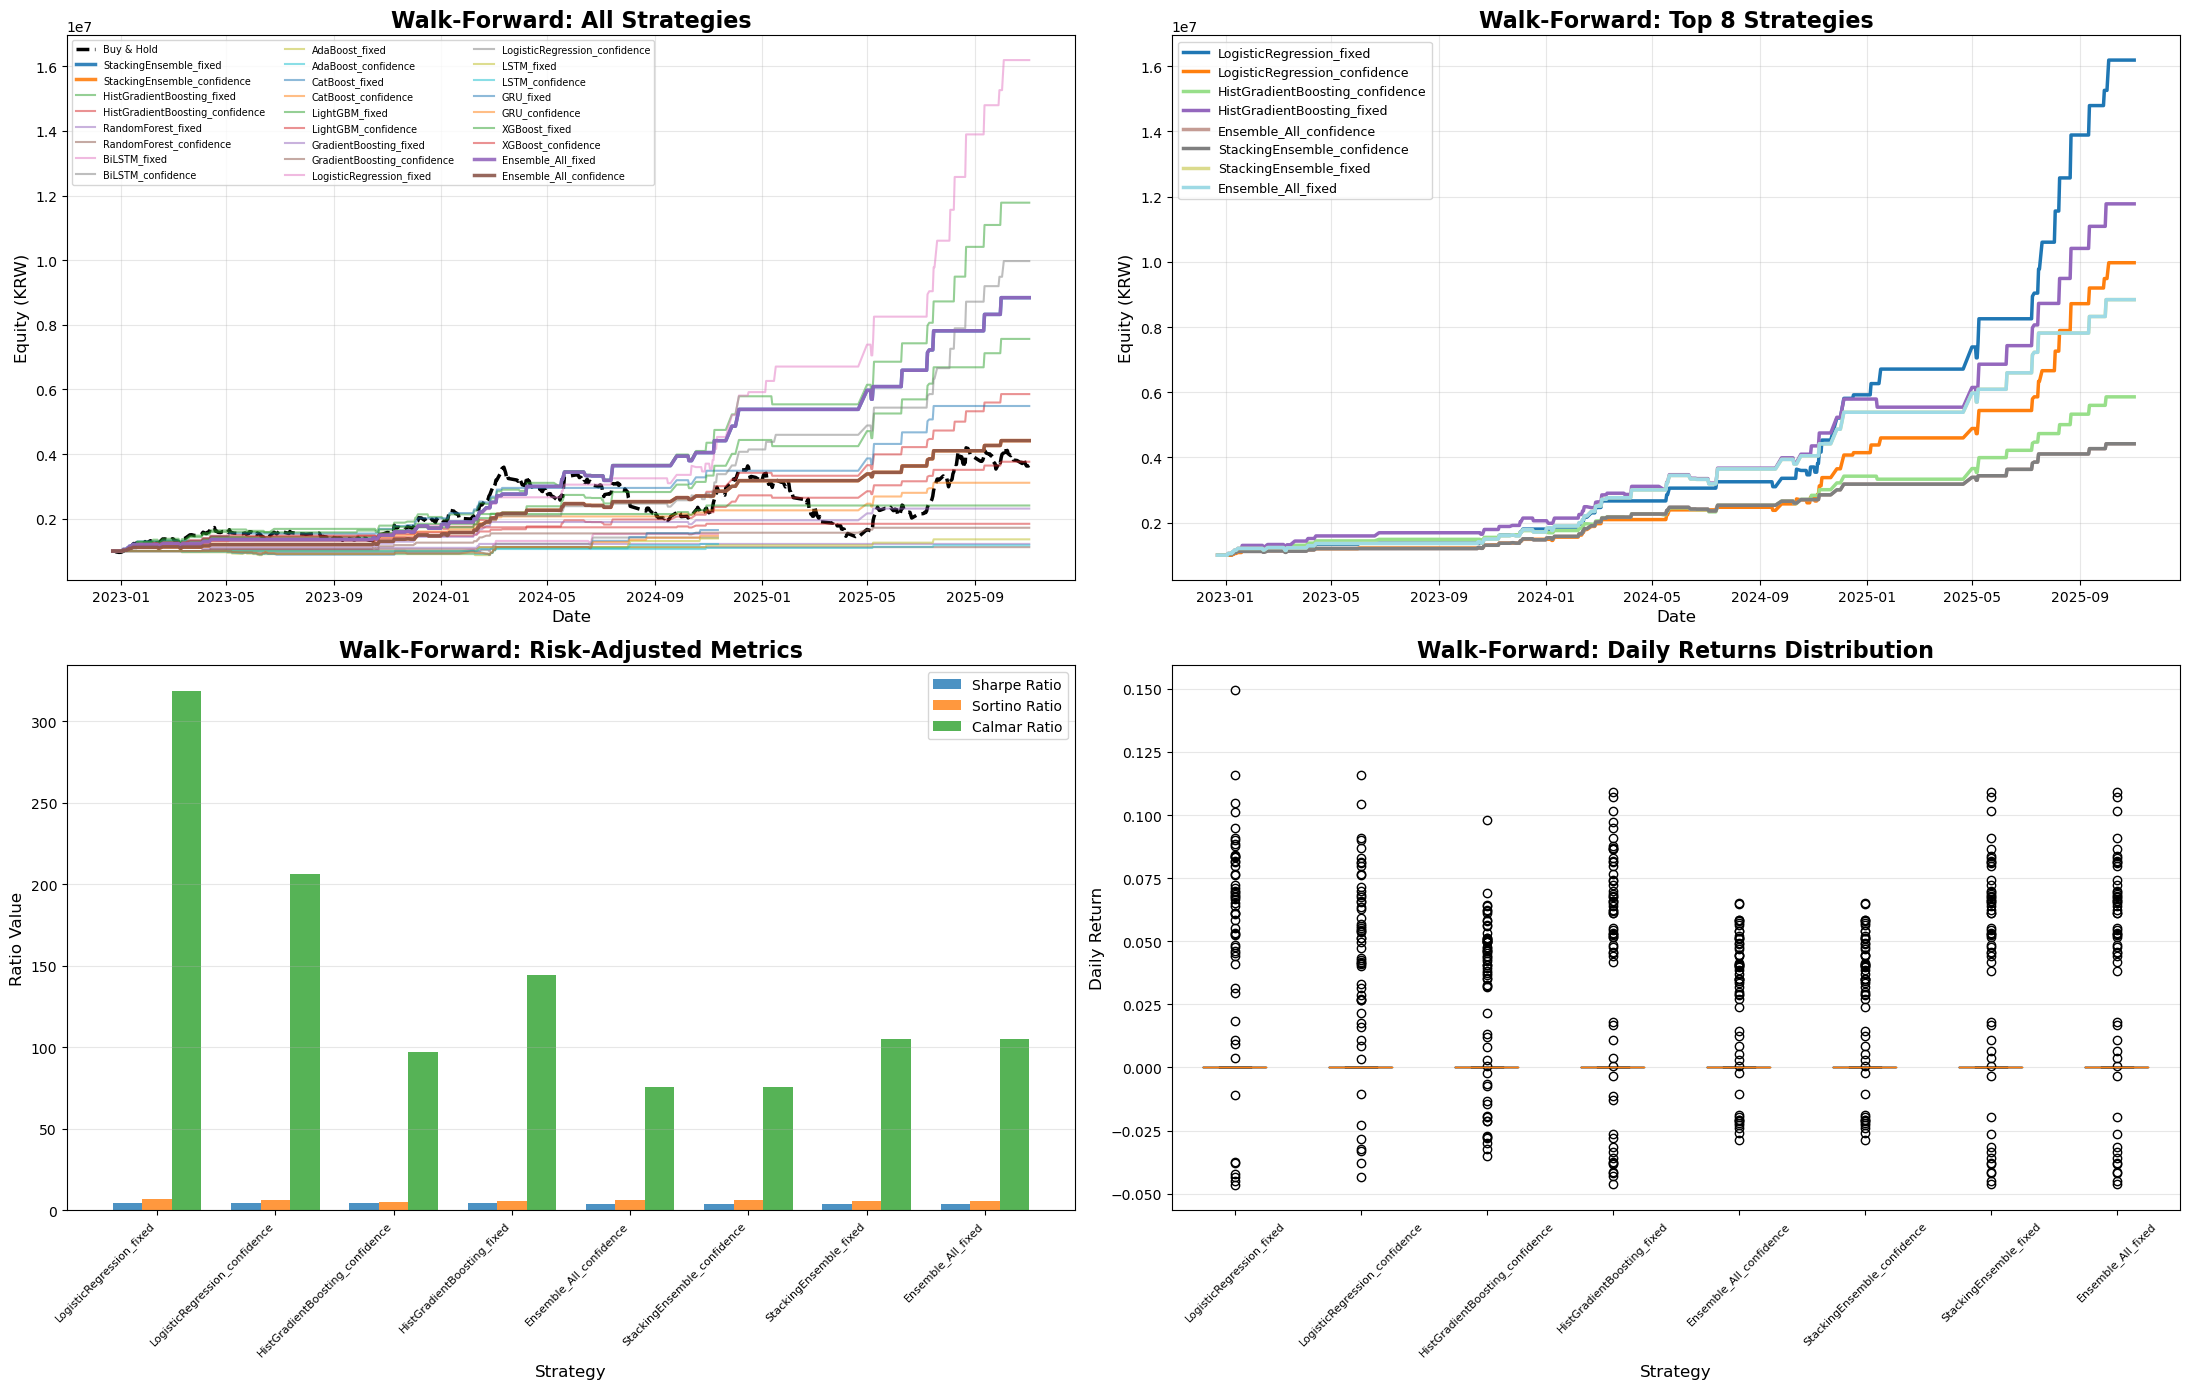


Walk-Forward: COMPREHENSIVE PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Recovery Factor Win Rate Profit Factor Max Consecutive Losses Total Trades P-Value Exposure Time Stop Loss Rate Take Profit Rate Avg Trade Duration
LogisticRegression_fixed             1519.09%   -4.77%        4.440         6.594      318.315         318.315   87.27%         1.659                      2           55  0.0000         8.62%         10.91%           81.82%                2.3
LogisticRegression_confidence         897.25%   -4.35%        4.374         6.287      206.404         206.404   87.27%         1.727                      2           55  0.0000         8.62%         10.91%           81.82%                2.3
HistGradientBoosting_confidence       485.67%   -5.01%        4.100         5.214       96.845          96.845   76.19%         2.103                      3           63  0.0000         9.87%         19.05%           76.19


Final Holdout: OUT-OF-SAMPLE DEGRADATION ANALYSIS
                                WF Sharpe HO Sharpe Degradation Ratio WF Returns HO Returns
GRU_confidence                      1.695     4.391             2.591     47.39%     86.36%
GRU_fixed                           1.691     4.339             2.566     65.08%    132.93%
LSTM_confidence                     1.281     2.646             2.066     21.84%     27.03%
LSTM_fixed                          1.446     2.476             1.712     39.11%     39.10%
GradientBoosting_fixed              2.699     3.871             1.435    131.41%     95.56%
GradientBoosting_confidence         2.763     3.859             1.397     72.10%     54.61%
AdaBoost_fixed                      1.678     1.952             1.163     36.25%     15.51%
AdaBoost_confidence                 1.687     1.948             1.154     17.86%      7.69%
BiLSTM_confidence                   1.816     2.003             1.103     41.80%     15.03%
LightGBM_confidence          

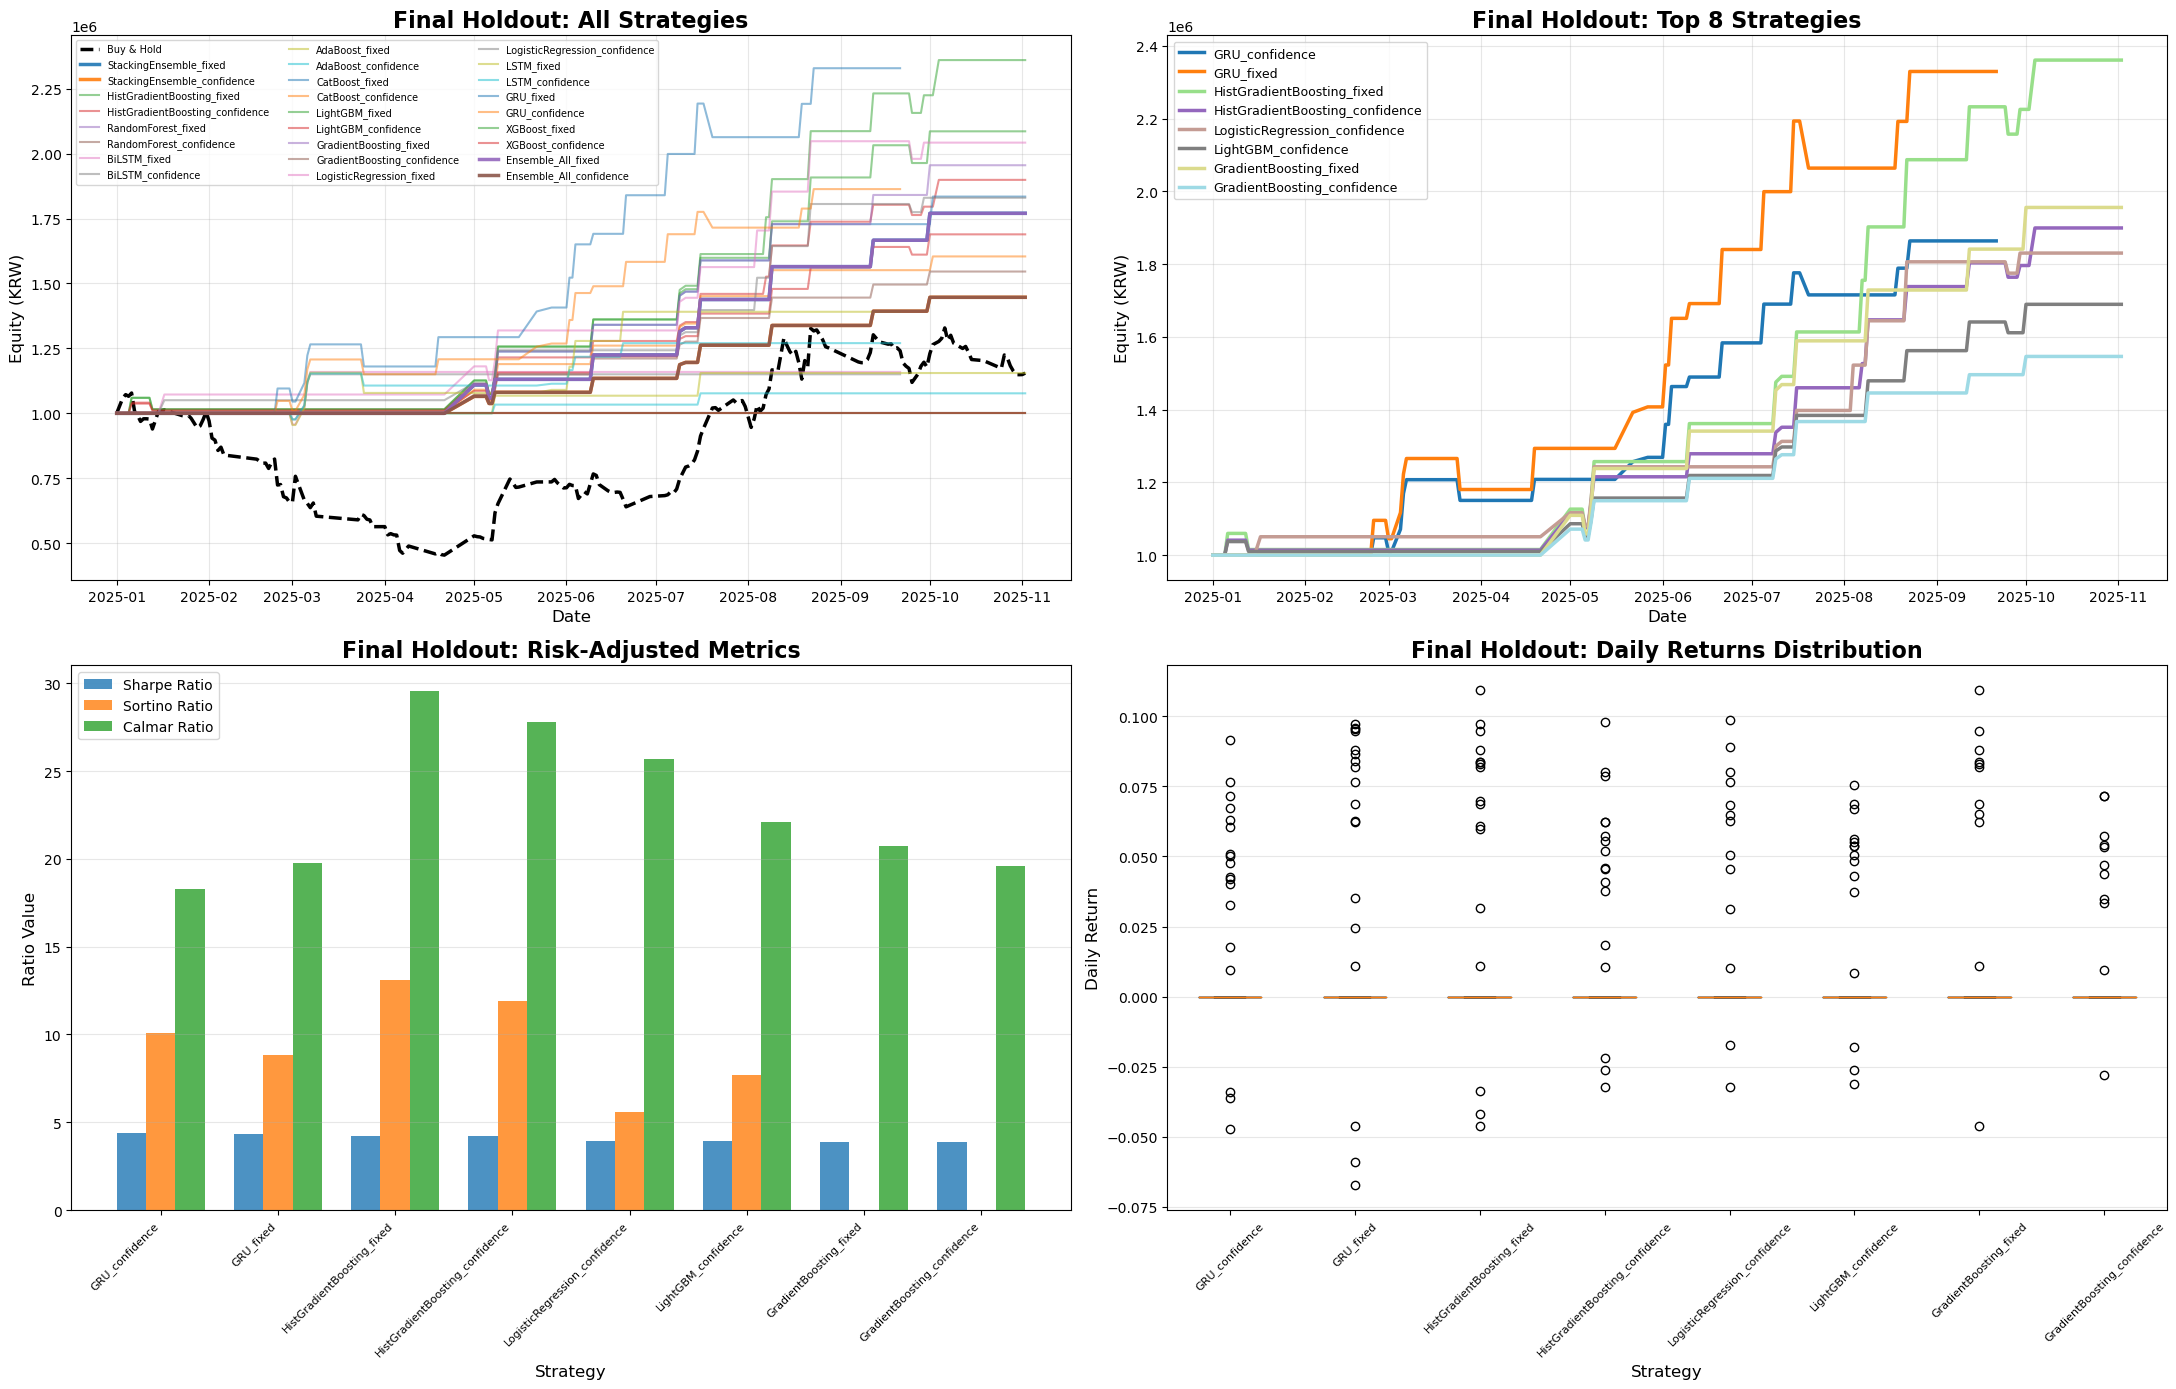


Final Holdout: COMPREHENSIVE PERFORMANCE SUMMARY
                                Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Recovery Factor Win Rate Profit Factor Max Consecutive Losses Total Trades P-Value Exposure Time Stop Loss Rate Take Profit Rate Avg Trade Duration
GRU_confidence                         86.36%   -4.72%        4.391        10.083       18.302          18.302   83.33%         1.239                      1           18  0.0016        11.18%         16.67%           77.78%                2.2
GRU_fixed                             132.93%   -6.73%        4.339         8.836       19.747          19.747   83.33%         1.152                      1           18  0.0019        11.18%         16.67%           77.78%                2.2
HistGradientBoosting_fixed            136.06%   -4.61%        4.231        13.114       29.542          29.542   82.35%         1.697                      1           17  0.0006         8.90%         17.65%           82.3


Walk-Forward Stress: STRESS VS NORMAL PERFORMANCE COMPARISON
Note: This shows performance during high volatility periods only


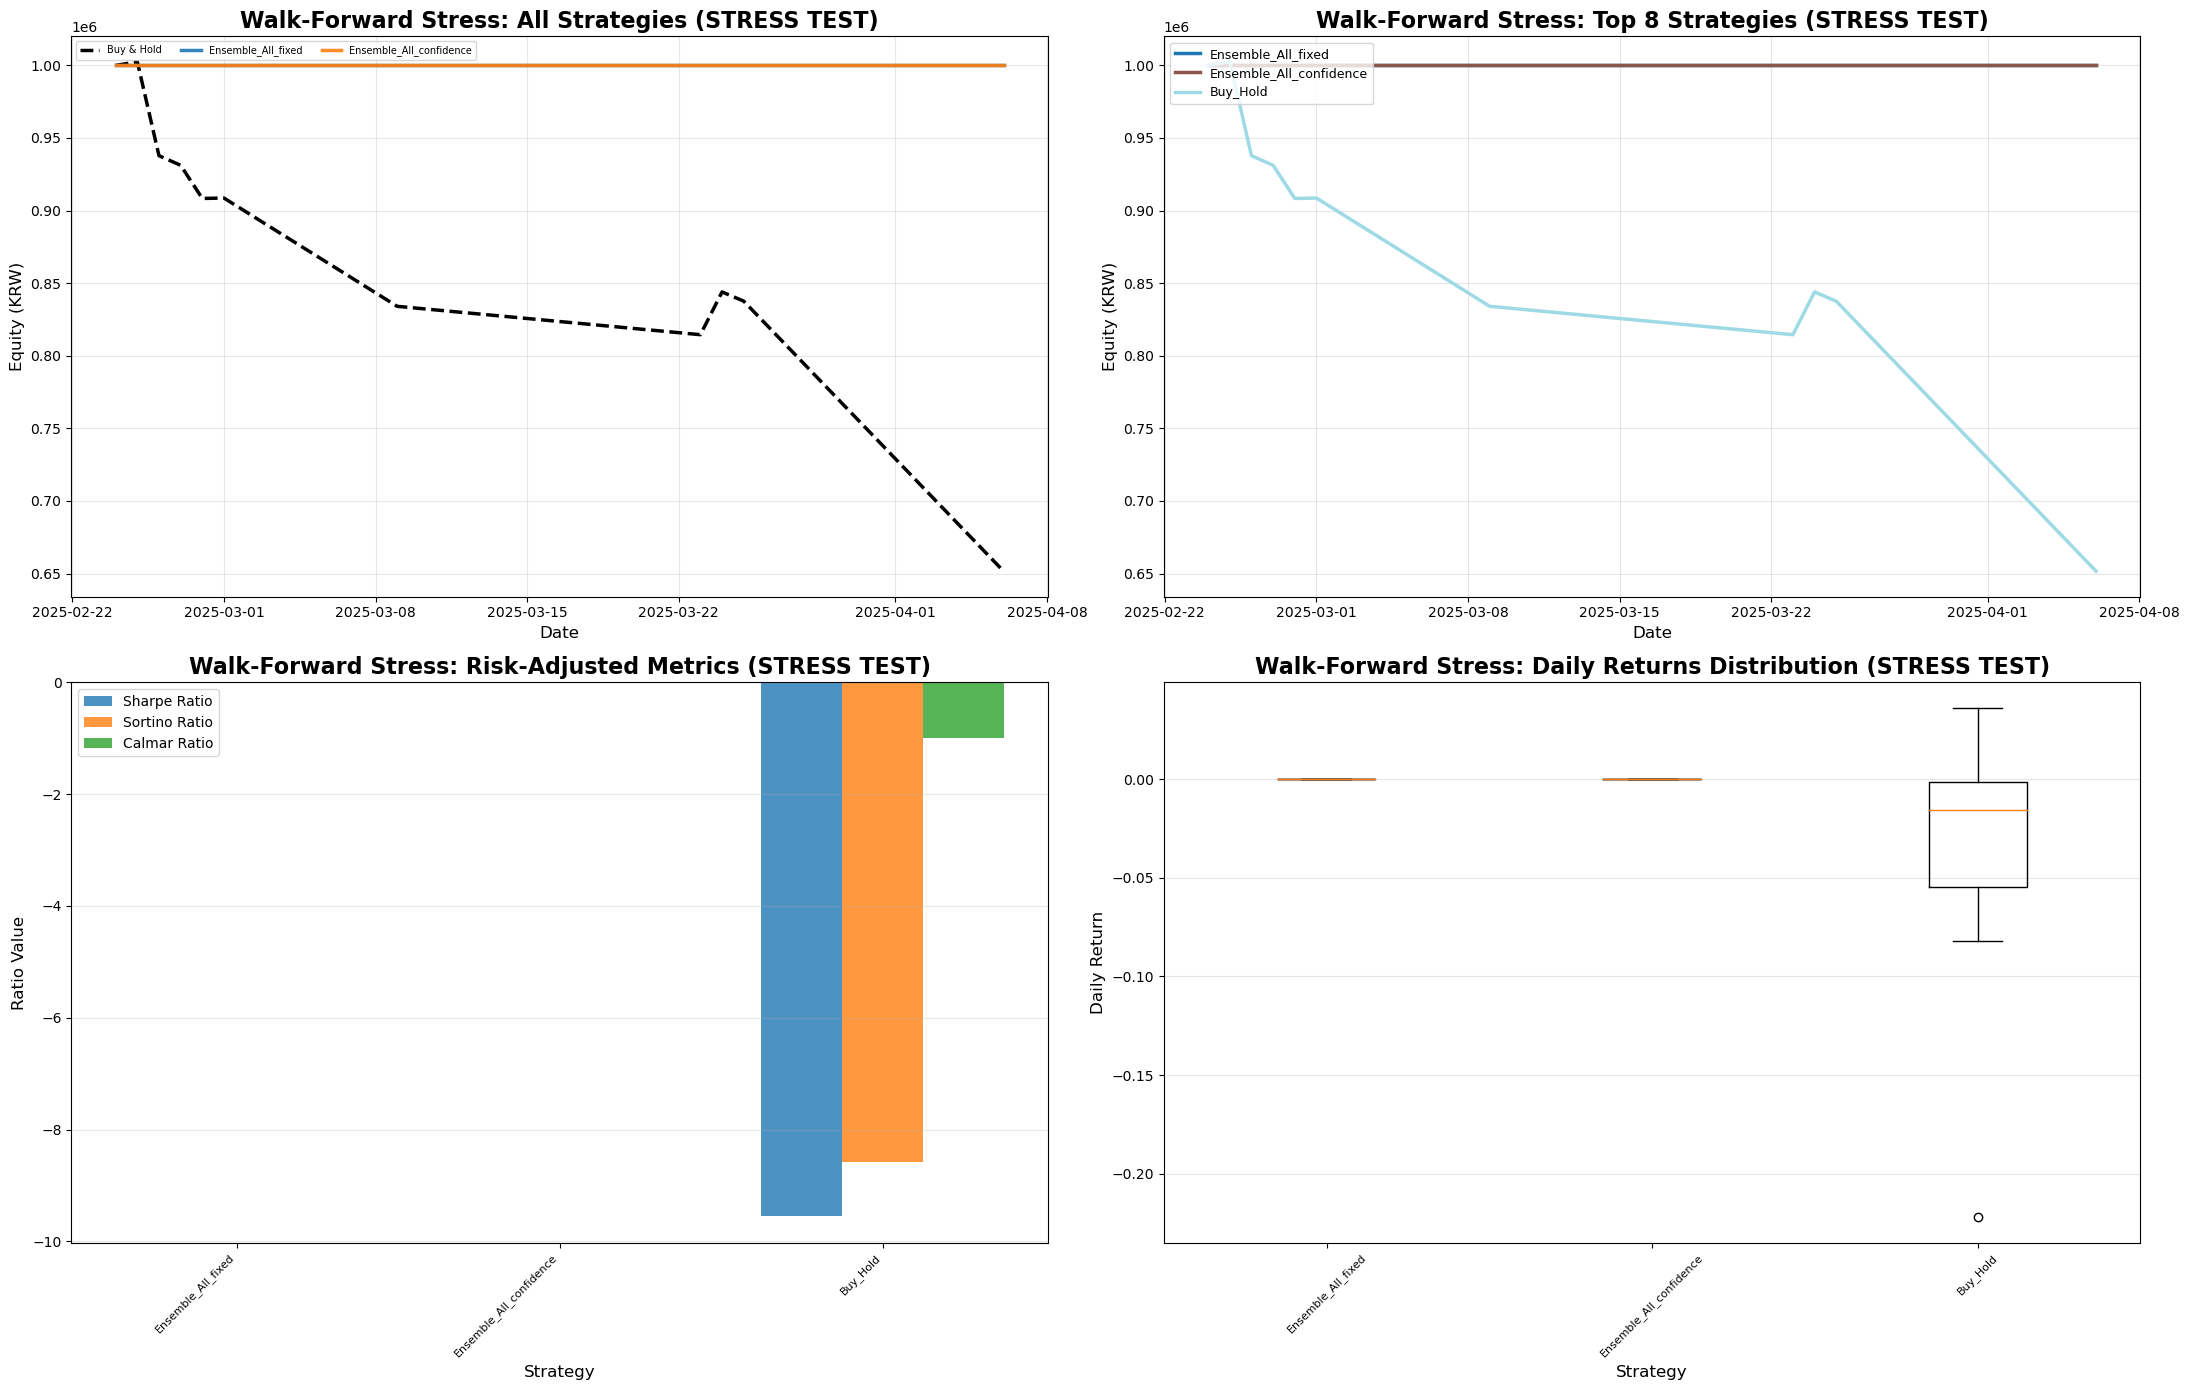


Walk-Forward Stress: COMPREHENSIVE PERFORMANCE SUMMARY (STRESS TEST)
                        Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Recovery Factor Win Rate Profit Factor Max Consecutive Losses Total Trades P-Value Exposure Time Stop Loss Rate Take Profit Rate Avg Trade Duration
Ensemble_All_fixed              0.00%    0.00%        0.000         0.000        0.000           0.000    0.00%         0.000                      0            0  1.0000         0.00%          0.00%            0.00%                0.0
Ensemble_All_confidence         0.00%    0.00%        0.000         0.000        0.000           0.000    0.00%         0.000                      0            0  1.0000         0.00%          0.00%            0.00%                0.0
Buy_Hold                      -34.84%  -35.00%       -9.546        -8.586       -0.995          -0.995   30.00%         0.191                      3           10  0.1289        90.91%          0.00%            0.00%          

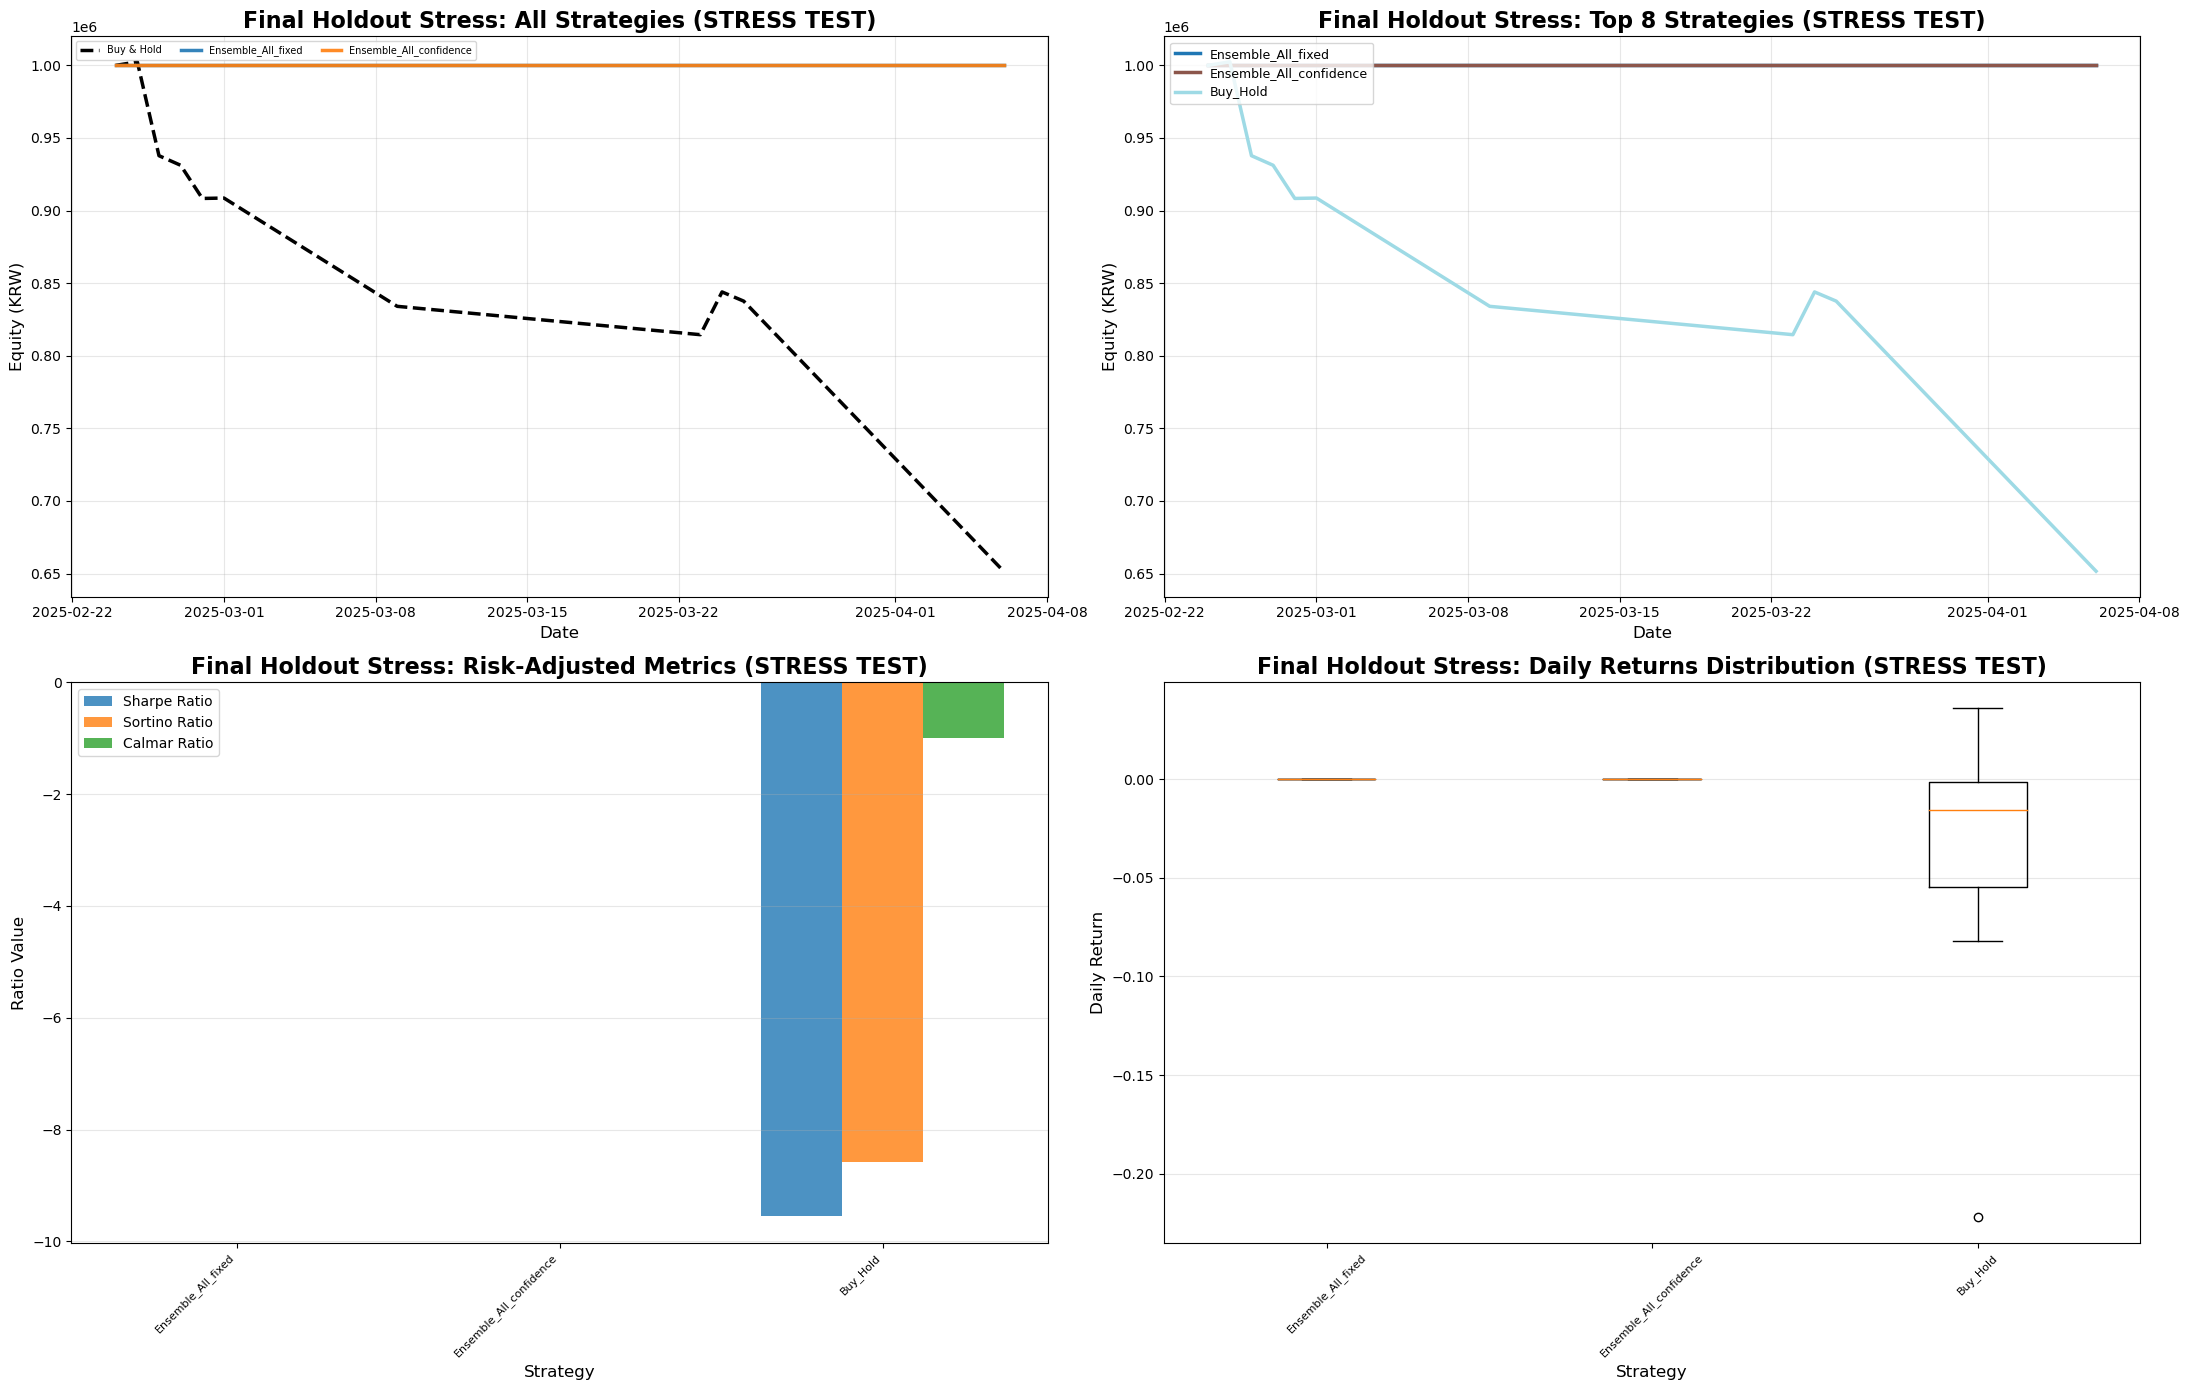


Final Holdout Stress: COMPREHENSIVE PERFORMANCE SUMMARY (STRESS TEST)
                        Total Returns      MDD Sharpe Ratio Sortino Ratio Calmar Ratio Recovery Factor Win Rate Profit Factor Max Consecutive Losses Total Trades P-Value Exposure Time Stop Loss Rate Take Profit Rate Avg Trade Duration
Ensemble_All_fixed              0.00%    0.00%        0.000         0.000        0.000           0.000    0.00%         0.000                      0            0  1.0000         0.00%          0.00%            0.00%                0.0
Ensemble_All_confidence         0.00%    0.00%        0.000         0.000        0.000           0.000    0.00%         0.000                      0            0  1.0000         0.00%          0.00%            0.00%                0.0
Buy_Hold                      -34.84%  -35.00%       -9.546        -8.586       -0.995          -0.995   30.00%         0.191                      3           10  0.1289        90.91%          0.00%            0.00%         

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from scipy import stats

def calculate_consecutive_metrics(returns_series):
    """연속 승/패 계산"""
    if len(returns_series) == 0:
        return 0, 0
    
    wins = (returns_series > 0).astype(int)
    losses = (returns_series < 0).astype(int)
    
    max_consecutive_wins = 0
    max_consecutive_losses = 0
    current_wins = 0
    current_losses = 0
    
    for r in returns_series:
        if r > 0:
            current_wins += 1
            current_losses = 0
            max_consecutive_wins = max(max_consecutive_wins, current_wins)
        elif r < 0:
            current_losses += 1
            current_wins = 0
            max_consecutive_losses = max(max_consecutive_losses, current_losses)
        else:
            current_wins = 0
            current_losses = 0
    
    return max_consecutive_wins, max_consecutive_losses

def calculate_var_cvar(returns, confidence=0.95):
    """VaR과 CVaR 계산"""
    if len(returns) == 0:
        return 0, 0
    
    var = np.percentile(returns, (1 - confidence) * 100)
    cvar = returns[returns <= var].mean() if len(returns[returns <= var]) > 0 else var
    
    return var, cvar

def calculate_performance_metrics(equity_curve, daily_returns, trade_details=None):
    """확장된 성과 지표 계산"""
    
    # 기본 수익률 지표
    total_returns = (equity_curve.iloc[-1] / equity_curve.iloc[0]) - 1
    
    # Drawdown 계산
    rolling_max = equity_curve.cummax()
    drawdown = (equity_curve - rolling_max) / rolling_max
    mdd = drawdown.min()
    
    # 리스크 조정 수익률
    sharpe_ratio = (daily_returns.mean() / daily_returns.std()) * np.sqrt(365) if daily_returns.std() != 0 else 0
    
    downside_returns = daily_returns[daily_returns < 0]
    sortino_ratio = (daily_returns.mean() / downside_returns.std()) * np.sqrt(365) if len(downside_returns) > 0 and downside_returns.std() != 0 else 0
    
    calmar_ratio = (total_returns / abs(mdd)) if mdd != 0 else 0
    
    # Recovery Factor
    recovery_factor = total_returns / abs(mdd) if mdd != 0 else 0
    
    # 거래 통계
    non_zero_returns = daily_returns[daily_returns != 0]
    win_rate = len(non_zero_returns[non_zero_returns > 0]) / len(non_zero_returns) if len(non_zero_returns) > 0 else 0
    
    avg_win = non_zero_returns[non_zero_returns > 0].mean() if len(non_zero_returns[non_zero_returns > 0]) > 0 else 0
    avg_loss = non_zero_returns[non_zero_returns < 0].mean() if len(non_zero_returns[non_zero_returns < 0]) > 0 else 0
    profit_factor = abs(avg_win / avg_loss) if avg_loss != 0 else 0
    
    # 연속 승/패
    max_consecutive_wins, max_consecutive_losses = calculate_consecutive_metrics(non_zero_returns)
    
    # 통계적 유의성
    t_stat = 0
    p_value = 1
    if len(non_zero_returns) > 1 and non_zero_returns.std() != 0:
        t_stat = (non_zero_returns.mean() / non_zero_returns.std()) * np.sqrt(len(non_zero_returns))
        p_value = stats.t.sf(abs(t_stat), len(non_zero_returns)-1) * 2
    
    # VaR & CVaR
    var_95, cvar_95 = calculate_var_cvar(non_zero_returns, 0.95)
    
    # Exposure Time
    total_trades = len(non_zero_returns)
    exposure_time = total_trades / len(daily_returns) if len(daily_returns) > 0 else 0
    
    # Trade details 분석
    avg_trade_duration = 0
    stop_loss_rate = 0
    take_profit_rate = 0
    time_exit_rate = 0
    
    if trade_details is not None and len(trade_details) > 0:
        durations = [t['duration'] for t in trade_details if 'duration' in t]
        avg_trade_duration = np.mean(durations) if len(durations) > 0 else 0
        
        total_exits = len(trade_details)
        stop_loss_exits = len([t for t in trade_details if t.get('exit_reason') == 'stop_loss'])
        take_profit_exits = len([t for t in trade_details if t.get('exit_reason') == 'take_profit'])
        time_exits = len([t for t in trade_details if t.get('exit_reason') == 'time_exit'])
        
        if total_exits > 0:
            stop_loss_rate = stop_loss_exits / total_exits
            take_profit_rate = take_profit_exits / total_exits
            time_exit_rate = time_exits / total_exits
    
    return {
        "Total Returns": total_returns,
        "MDD": mdd,
        "Sharpe Ratio": sharpe_ratio,
        "Sortino Ratio": sortino_ratio,
        "Calmar Ratio": calmar_ratio,
        "Recovery Factor": recovery_factor,
        "Win Rate": win_rate,
        "Profit Factor": profit_factor,
        "Avg Win": avg_win,
        "Avg Loss": avg_loss,
        "Avg Trade": daily_returns.mean(),
        "Max Consecutive Wins": max_consecutive_wins,
        "Max Consecutive Losses": max_consecutive_losses,
        "Total Trades": total_trades,
        "T-Statistic": t_stat,
        "P-Value": p_value,
        "Exposure Time": exposure_time,
        "VaR (95%)": var_95,
        "CVaR (95%)": cvar_95,
        "Avg Trade Duration": avg_trade_duration,
        "Stop Loss Rate": stop_loss_rate,
        "Take Profit Rate": take_profit_rate,
        "Time Exit Rate": time_exit_rate
    }

def calculate_kelly_criterion(win_rate, avg_win, avg_loss):
    """Kelly Criterion 계산"""
    if avg_loss == 0 or win_rate == 0:
        return 0
    win_loss_ratio = abs(avg_win / avg_loss)
    kelly = (win_rate * win_loss_ratio - (1 - win_rate)) / win_loss_ratio
    return max(0, min(kelly, 0.25))

def calculate_dynamic_slippage(price_df, current_idx, base_slippage=0.0005, atr_window=14):
    """ATR 기반 동적 슬리피지 계산"""
    if current_idx < atr_window:
        return base_slippage
    
    recent_data = price_df.iloc[max(0, current_idx - atr_window):current_idx + 1]
    
    tr1 = recent_data['ETH_High'] - recent_data['ETH_Low']
    tr2 = abs(recent_data['ETH_High'] - recent_data['ETH_Close'].shift(1))
    tr3 = abs(recent_data['ETH_Low'] - recent_data['ETH_Close'].shift(1))
    tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
    current_atr = tr.mean()
    
    atr_ratio = current_atr / recent_data['ETH_Close'].iloc[-1]
    
    volume_ratio = 1.0
    if 'ETH_Volume' in recent_data.columns:
        avg_volume = recent_data['ETH_Volume'].mean()
        current_volume = recent_data['ETH_Volume'].iloc[-1]
        volume_ratio = current_volume / avg_volume if avg_volume > 0 else 1.0
    
    atr_multiplier = min(atr_ratio / 0.02, 3.0)
    volume_multiplier = max(0.5, min(2.0 / volume_ratio, 2.0)) if volume_ratio < 1 else 1.0
    
    dynamic_slippage = base_slippage * (1 + atr_multiplier * 0.5 + (volume_multiplier - 1) * 0.3)
    
    return min(dynamic_slippage, base_slippage * 5)

def check_liquidity_constraint(price_df, current_idx, capital_krw, min_volume_ratio=0.01):
    """유동성 제약 확인"""
    if 'ETH_Volume' in price_df.columns:
        current_price = price_df.loc[current_idx, 'ETH_Close']
        daily_volume_krw = price_df.loc[current_idx, 'ETH_Volume'] * current_price
        
        if capital_krw > daily_volume_krw * min_volume_ratio:
            return False
    
    return True

def dynamic_position_sizing(predictions_df, price_df, lookahead, sizing_method='fixed', 
                           fee_rate=0.0005, base_slippage=0.0005, 
                           use_dynamic_slippage=True, use_liquidity_constraint=False,
                           capital=1_000_000):
    """동적 포지션 사이징 백테스트 - 거래 세부사항 추적 포함"""
    
    predictions_df['date'] = pd.to_datetime(predictions_df['date'])
    sim_df = pd.merge(predictions_df, price_df, on='date', how='inner').sort_values(by='date').reset_index(drop=True)
    
    daily_log_returns = pd.Series(0.0, index=sim_df.index)
    position = None
    trade_details = []
    
    for i in range(len(sim_df)):
        current_slippage = calculate_dynamic_slippage(sim_df, i, base_slippage) if use_dynamic_slippage else base_slippage
        
        if position:
            days_in_trade = i - position['entry_day_index']
            exit_price = None
            exit_reason = None
            
            if sim_df.loc[i, 'ETH_Low'] <= position['stop_loss']:
                exit_price = position['stop_loss']
                exit_reason = 'stop_loss'
            elif sim_df.loc[i, 'ETH_High'] >= position['take_profit']:
                exit_price = position['take_profit']
                exit_reason = 'take_profit'
            elif days_in_trade >= lookahead:
                if i + 1 < len(sim_df):
                    exit_price = sim_df.loc[i + 1, 'ETH_Open']
                else:
                    exit_price = sim_df.loc[i, 'ETH_Close']
                exit_reason = 'time_exit'

            if exit_price:
                total_cost = current_slippage + fee_rate
                actual_exit_price = exit_price * (1 - total_cost)
                
                trade_return = np.log(actual_exit_price / position['entry_price'])
                daily_log_returns.iloc[i] = trade_return * position['size']
                
                trade_details.append({
                    'return': trade_return * position['size'],
                    'exit_reason': exit_reason,
                    'duration': days_in_trade,
                    'entry_date': position['entry_date'],
                    'exit_date': sim_df.loc[i, 'date']
                })
                
                position = None
        
        if not position and sim_df.loc[i, 'signal'] == 1 and (i + 1 < len(sim_df)):
            if use_liquidity_constraint and not check_liquidity_constraint(sim_df, i, capital):
                continue
            
            if sizing_method == 'fixed':
                position_size = 1.0
            elif sizing_method == 'confidence':
                position_size = sim_df.loc[i, 'confidence']
            elif sizing_method == 'kelly' and len(trade_details) >= 20:
                recent_trades = [t['return'] for t in trade_details[-20:]]
                recent_series = pd.Series(recent_trades)
                win_rate = len(recent_series[recent_series > 0]) / len(recent_series)
                avg_win = recent_series[recent_series > 0].mean() if len(recent_series[recent_series > 0]) > 0 else 0
                avg_loss = recent_series[recent_series < 0].mean() if len(recent_series[recent_series < 0]) > 0 else 0
                position_size = calculate_kelly_criterion(win_rate, avg_win, avg_loss)
            else:
                position_size = 1.0
            
            entry_slippage = calculate_dynamic_slippage(sim_df, i + 1, base_slippage) if use_dynamic_slippage else base_slippage
            total_entry_cost = entry_slippage + fee_rate
            entry_price = sim_df.loc[i + 1, 'ETH_Open'] * (1 + total_entry_cost)
            
            position = {
                'entry_price': entry_price,
                'take_profit': sim_df.loc[i, 'take_profit_price'],
                'stop_loss': sim_df.loc[i, 'stop_loss_price'],
                'entry_day_index': i + 1,
                'entry_date': sim_df.loc[i + 1, 'date'],
                'size': position_size
            }
            
    return daily_log_returns, trade_details

def identify_stress_periods(price_df, window=30):
    """스트레스 구간 식별"""
    price_df = price_df.copy()
    price_df['returns'] = price_df['ETH_Close'].pct_change()
    price_df['rolling_vol'] = price_df['returns'].rolling(window).std()
    price_df['rolling_dd'] = (price_df['ETH_Close'] / price_df['ETH_Close'].rolling(window).max() - 1)
    
    high_vol_threshold = price_df['rolling_vol'].quantile(0.90)
    high_dd_threshold = price_df['rolling_dd'].quantile(0.10)
    
    stress_periods = price_df[
        (price_df['rolling_vol'] > high_vol_threshold) | 
        (price_df['rolling_dd'] < high_dd_threshold)
    ]['date'].values
    
    return stress_periods

def calculate_fold_statistics(fold_performance):
    """Fold 간 일관성 통계 계산"""
    if len(fold_performance) <= 1:
        return {}
    
    sharpe_ratios = [metrics['Sharpe Ratio'] for metrics in fold_performance.values() if 'Buy_Hold' not in str(metrics)]
    
    if len(sharpe_ratios) == 0:
        return {}
    
    cv_sharpe = np.std(sharpe_ratios) / np.mean(sharpe_ratios) if np.mean(sharpe_ratios) != 0 else float('inf')
    best_worst_ratio = min(sharpe_ratios) / max(sharpe_ratios) if max(sharpe_ratios) != 0 else 0
    
    return {
        "CV of Sharpe": cv_sharpe,
        "Best/Worst Fold": best_worst_ratio,
        "Mean Sharpe": np.mean(sharpe_ratios),
        "Std Sharpe": np.std(sharpe_ratios)
    }

def run_separated_backtest(pred_base_path, master_raw_file_path, confidence_threshold=0.5, 
                           lookahead=5, initial_capital=1_000_000,
                           use_dynamic_slippage=True, use_liquidity_constraint=False,
                           run_stress_test=True):
    
    price_df = pd.read_csv(master_raw_file_path, usecols=['date', 'ETH_Open', 'ETH_High', 'ETH_Low', 'ETH_Close'])
    price_df['date'] = pd.to_datetime(price_df['date'])

    all_pred_files = glob.glob(os.path.join(pred_base_path, "fold_*", "*_predictions.csv"))
    
    wf_files = [f for f in all_pred_files if 'final_holdout' not in f]
    ho_files = [f for f in all_pred_files if 'final_holdout' in f]
    
    wf_model_files = {}
    for f in wf_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        fold_name = os.path.basename(os.path.dirname(f))
        if model_name not in wf_model_files:
            wf_model_files[model_name] = {}
        if fold_name not in wf_model_files[model_name]:
            wf_model_files[model_name][fold_name] = []
        wf_model_files[model_name][fold_name].append(f)
    
    ho_model_files = {}
    for f in ho_files:
        model_name = os.path.basename(f).replace('_predictions.csv', '')
        fold_name = os.path.basename(os.path.dirname(f))
        if model_name not in ho_model_files:
            ho_model_files[model_name] = {}
        if fold_name not in ho_model_files[model_name]:
            ho_model_files[model_name][fold_name] = []
        ho_model_files[model_name][fold_name].append(f)

    stress_periods = identify_stress_periods(price_df) if run_stress_test else []

    def backtest_per_fold(model_files_dict, period_name):
        all_folds = sorted(set([fold for files_by_fold in model_files_dict.values() for fold in files_by_fold.keys()]))
        
        fold_performance = {}
        
        for fold in all_folds:
            fold_results = {}
            
            fold_files = []
            for model_name, files_by_fold in model_files_dict.items():
                if fold in files_by_fold:
                    fold_files.extend(files_by_fold[fold])
            
            if not fold_files:
                continue
            
            all_dates_df = pd.concat([pd.read_csv(f)[['date']] for f in fold_files]).drop_duplicates().sort_values('date')
            all_test_dates = pd.to_datetime(all_dates_df['date'])
            
            bnh_df = price_df[price_df['date'].isin(all_test_dates)].copy().reset_index(drop=True)
            if len(bnh_df) == 0:
                continue
            
            bnh_df['bnh_return'] = np.log(bnh_df['ETH_Close'] / bnh_df['ETH_Close'].shift(1)).fillna(0)
            bnh_equity = initial_capital * np.exp(bnh_df['bnh_return'].cumsum())
            bnh_metrics = calculate_performance_metrics(bnh_equity, bnh_df['bnh_return'])
            fold_results['Buy_Hold'] = bnh_metrics
            
            for model_name in model_files_dict.keys():
                if fold not in model_files_dict[model_name]:
                    continue
                
                files = model_files_dict[model_name][fold]
                preds_df = pd.concat([pd.read_csv(f) for f in files]).drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
                preds_df['signal'] = np.where((preds_df['pred_direction'] == 1) & (preds_df['confidence'] >= confidence_threshold), 1, 0)
                
                for sizing_method in ['fixed', 'confidence']:
                    strategy_log_returns, trade_details = dynamic_position_sizing(
                        preds_df, price_df, lookahead, 
                        sizing_method=sizing_method,
                        use_dynamic_slippage=use_dynamic_slippage,
                        use_liquidity_constraint=use_liquidity_constraint,
                        capital=initial_capital
                    )
                    strategy_equity = initial_capital * np.exp(strategy_log_returns.cumsum())
                    
                    if len(strategy_equity) > 0:
                        strategy_key = f"{model_name}_{sizing_method}"
                        fold_results[strategy_key] = calculate_performance_metrics(
                            strategy_equity, strategy_log_returns, trade_details
                        )
            
            fold_performance[fold] = fold_results
        
        print("="*150)
        print(f"{period_name}: PER-FOLD PERFORMANCE COMPARISON")
        print("="*150)
        
        for fold in sorted(fold_performance.keys()):
            print(f"\n{fold}:")
            print("-"*150)
            
            fold_df = pd.DataFrame.from_dict(fold_performance[fold], orient='index')
            fold_df = fold_df.sort_values('Sharpe Ratio', ascending=False)
            
            display_df = fold_df[['Total Returns', 'MDD', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio', 
                                   'Recovery Factor', 'Win Rate', 'Profit Factor', 'Max Consecutive Losses',
                                   'Total Trades', 'P-Value', 'Exposure Time']].copy()
            
            display_df['Total Returns'] = display_df['Total Returns'].apply(lambda x: f"{x:.2%}")
            display_df['MDD'] = display_df['MDD'].apply(lambda x: f"{x:.2%}")
            display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
            display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
            display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
            display_df['Recovery Factor'] = display_df['Recovery Factor'].apply(lambda x: f"{x:.3f}")
            display_df['Win Rate'] = display_df['Win Rate'].apply(lambda x: f"{x:.2%}")
            display_df['Profit Factor'] = display_df['Profit Factor'].apply(lambda x: f"{x:.3f}")
            display_df['Max Consecutive Losses'] = display_df['Max Consecutive Losses'].apply(lambda x: f"{int(x)}")
            display_df['Total Trades'] = display_df['Total Trades'].apply(lambda x: f"{int(x)}")
            display_df['P-Value'] = display_df['P-Value'].apply(lambda x: f"{x:.4f}")
            display_df['Exposure Time'] = display_df['Exposure Time'].apply(lambda x: f"{x:.2%}")
            
            print(display_df.to_string())
        
        # Fold 간 일관성 통계
        strategy_keys = set()
        for fold_results in fold_performance.values():
            strategy_keys.update([k for k in fold_results.keys() if k != 'Buy_Hold'])
        
        print("\n" + "="*150)
        print(f"{period_name}: FOLD CONSISTENCY ANALYSIS")
        print("="*150)
        
        consistency_results = {}
        for strategy in strategy_keys:
            strategy_fold_metrics = {}
            for fold, results in fold_performance.items():
                if strategy in results:
                    strategy_fold_metrics[fold] = results[strategy]
            
            if len(strategy_fold_metrics) > 1:
                sharpes = [m['Sharpe Ratio'] for m in strategy_fold_metrics.values()]
                returns = [m['Total Returns'] for m in strategy_fold_metrics.values()]
                
                consistency_results[strategy] = {
                    'Mean Sharpe': np.mean(sharpes),
                    'Std Sharpe': np.std(sharpes),
                    'CV Sharpe': np.std(sharpes) / np.mean(sharpes) if np.mean(sharpes) != 0 else float('inf'),
                    'Min Sharpe': min(sharpes),
                    'Max Sharpe': max(sharpes),
                    'Best/Worst': min(sharpes) / max(sharpes) if max(sharpes) != 0 else 0,
                    'Mean Return': np.mean(returns),
                    'Std Return': np.std(returns)
                }
        
        if consistency_results:
            consistency_df = pd.DataFrame.from_dict(consistency_results, orient='index')
            consistency_df = consistency_df.sort_values('Mean Sharpe', ascending=False)
            
            display_consistency = consistency_df.copy()
            display_consistency['Mean Sharpe'] = display_consistency['Mean Sharpe'].apply(lambda x: f"{x:.3f}")
            display_consistency['Std Sharpe'] = display_consistency['Std Sharpe'].apply(lambda x: f"{x:.3f}")
            display_consistency['CV Sharpe'] = display_consistency['CV Sharpe'].apply(lambda x: f"{x:.3f}")
            display_consistency['Min Sharpe'] = display_consistency['Min Sharpe'].apply(lambda x: f"{x:.3f}")
            display_consistency['Max Sharpe'] = display_consistency['Max Sharpe'].apply(lambda x: f"{x:.3f}")
            display_consistency['Best/Worst'] = display_consistency['Best/Worst'].apply(lambda x: f"{x:.3f}")
            display_consistency['Mean Return'] = display_consistency['Mean Return'].apply(lambda x: f"{x:.2%}")
            display_consistency['Std Return'] = display_consistency['Std Return'].apply(lambda x: f"{x:.2%}")
            
            print(display_consistency.to_string())
        
        print("="*150)
        
        return fold_performance

    def backtest_period(model_files_dict, period_name, stress_only=False, wf_performance=None):
        all_files = [f for files_by_fold in model_files_dict.values() for files in files_by_fold.values() for f in files]
        all_dates_df = pd.concat([pd.read_csv(f)[['date']] for f in all_files]).drop_duplicates().sort_values('date')
        all_test_dates = pd.to_datetime(all_dates_df['date'])
        
        if stress_only and len(stress_periods) > 0:
            all_test_dates = all_test_dates[all_test_dates.isin(stress_periods)]
            if len(all_test_dates) == 0:
                print(f"No stress periods found in {period_name}")
                return None
        
        performance_summary = {}
        all_equity_curves = {}
        all_trade_details = {}
        
        bnh_df = price_df[price_df['date'].isin(all_test_dates)].copy().reset_index(drop=True)
        bnh_df['bnh_return'] = np.log(bnh_df['ETH_Close'] / bnh_df['ETH_Close'].shift(1)).fillna(0)
        bnh_equity = initial_capital * np.exp(bnh_df['bnh_return'].cumsum())
        bnh_metrics = calculate_performance_metrics(bnh_equity, bnh_df['bnh_return'])
        performance_summary['Buy_Hold'] = bnh_metrics
        all_equity_curves['Buy_Hold'] = bnh_equity

        for model_name in model_files_dict.keys():
            all_model_files = [f for files in model_files_dict[model_name].values() for f in files]
            preds_df = pd.concat([pd.read_csv(f) for f in all_model_files]).drop_duplicates(subset=['date']).sort_values('date').reset_index(drop=True)
            preds_df['signal'] = np.where((preds_df['pred_direction'] == 1) & (preds_df['confidence'] >= confidence_threshold), 1, 0)
            
            if stress_only:
                preds_df = preds_df[preds_df['date'].isin(all_test_dates)]
            
            for sizing_method in ['fixed', 'confidence']:
                strategy_log_returns, trade_details = dynamic_position_sizing(
                    preds_df, price_df, lookahead, 
                    sizing_method=sizing_method,
                    use_dynamic_slippage=use_dynamic_slippage,
                    use_liquidity_constraint=use_liquidity_constraint,
                    capital=initial_capital
                )
                strategy_equity = initial_capital * np.exp(strategy_log_returns.cumsum())
                
                if len(strategy_equity) > 0:
                    strategy_key = f"{model_name}_{sizing_method}"
                    performance_summary[strategy_key] = calculate_performance_metrics(
                        strategy_equity, strategy_log_returns, trade_details
                    )
                    all_equity_curves[strategy_key] = strategy_equity
                    all_trade_details[strategy_key] = trade_details

        voting_threshold = 0.3
        ensemble_dates = all_dates_df.copy()
        ensemble_dates['date'] = pd.to_datetime(ensemble_dates['date'])
        
        if stress_only:
            ensemble_dates = ensemble_dates[ensemble_dates['date'].isin(all_test_dates)]
        
        ensemble_dates['vote'] = 0
        
        for model_name in model_files_dict.keys():
            all_model_files = [f for files in model_files_dict[model_name].values() for f in files]
            model_df = pd.concat([pd.read_csv(f) for f in all_model_files]).drop_duplicates(subset=['date']).sort_values('date')
            model_df['date'] = pd.to_datetime(model_df['date'])
            model_df['model_signal'] = np.where((model_df['pred_direction'] == 1) & (model_df['confidence'] >= confidence_threshold), 1, 0)
            
            ensemble_dates = pd.merge(ensemble_dates, model_df[['date', 'model_signal', 'take_profit_price', 'stop_loss_price', 'confidence']], 
                                      on='date', how='left', suffixes=('', f'_{model_name}'))
            ensemble_dates['vote'] += ensemble_dates['model_signal'].fillna(0)
            
            if 'take_profit_price' not in ensemble_dates.columns:
                ensemble_dates['take_profit_price'] = model_df['take_profit_price']
                ensemble_dates['stop_loss_price'] = model_df['stop_loss_price']
            
            if 'confidence' not in ensemble_dates.columns or pd.isna(ensemble_dates['confidence']).all():
                ensemble_dates['confidence'] = model_df['confidence']
        
        ensemble_dates['signal'] = np.where(ensemble_dates['vote'] >= len(model_files_dict) * voting_threshold, 1, 0)
        
        for sizing_method in ['fixed', 'confidence']:
            ensemble_log_returns, ensemble_trade_details = dynamic_position_sizing(
                ensemble_dates, price_df, lookahead, 
                sizing_method=sizing_method,
                use_dynamic_slippage=use_dynamic_slippage,
                use_liquidity_constraint=use_liquidity_constraint,
                capital=initial_capital
            )
            ensemble_equity = initial_capital * np.exp(ensemble_log_returns.cumsum())
            
            if len(ensemble_equity) > 0:
                strategy_key = f"Ensemble_All_{sizing_method}"
                performance_summary[strategy_key] = calculate_performance_metrics(
                    ensemble_equity, ensemble_log_returns, ensemble_trade_details
                )
                all_equity_curves[strategy_key] = ensemble_equity
                all_trade_details[strategy_key] = ensemble_trade_details

        # OOS Degradation 계산 (holdout period인 경우)
        if wf_performance is not None and not stress_only:
            print("\n" + "="*150)
            print(f"{period_name}: OUT-OF-SAMPLE DEGRADATION ANALYSIS")
            print("="*150)
            
            oos_analysis = {}
            for strategy in performance_summary.keys():
                if strategy != 'Buy_Hold' and strategy in wf_performance:
                    wf_sharpe = wf_performance[strategy]['Sharpe Ratio']
                    ho_sharpe = performance_summary[strategy]['Sharpe Ratio']
                    
                    degradation = ho_sharpe / wf_sharpe if wf_sharpe != 0 else 0
                    
                    oos_analysis[strategy] = {
                        'WF Sharpe': wf_sharpe,
                        'HO Sharpe': ho_sharpe,
                        'Degradation Ratio': degradation,
                        'WF Returns': wf_performance[strategy]['Total Returns'],
                        'HO Returns': performance_summary[strategy]['Total Returns']
                    }
            
            if oos_analysis:
                oos_df = pd.DataFrame.from_dict(oos_analysis, orient='index')
                oos_df = oos_df.sort_values('Degradation Ratio', ascending=False)
                
                display_oos = oos_df.copy()
                display_oos['WF Sharpe'] = display_oos['WF Sharpe'].apply(lambda x: f"{x:.3f}")
                display_oos['HO Sharpe'] = display_oos['HO Sharpe'].apply(lambda x: f"{x:.3f}")
                display_oos['Degradation Ratio'] = display_oos['Degradation Ratio'].apply(lambda x: f"{x:.3f}")
                display_oos['WF Returns'] = display_oos['WF Returns'].apply(lambda x: f"{x:.2%}")
                display_oos['HO Returns'] = display_oos['HO Returns'].apply(lambda x: f"{x:.2%}")
                
                print(display_oos.to_string())
                print("\nInterpretation:")
                print("  > 0.80: Excellent (minimal overfitting)")
                print("  0.60-0.80: Good (acceptable degradation)")
                print("  0.40-0.60: Moderate (some overfitting)")
                print("  < 0.40: Poor (significant overfitting)")
            
            print("="*150)

        # Stress Test 성과 비교
        if stress_only:
            print("\n" + "="*150)
            print(f"{period_name}: STRESS VS NORMAL PERFORMANCE COMPARISON")
            print("="*150)
            print("Note: This shows performance during high volatility periods only")
            print("="*150)

        fig, axes = plt.subplots(2, 2, figsize=(22, 14))
        
        axes[0, 0].plot(bnh_df['date'], bnh_equity, label='Buy & Hold', color='black', linestyle='--', linewidth=2.5)
        for strategy_name, equity in all_equity_curves.items():
            if strategy_name != 'Buy_Hold':
                alpha = 0.9 if 'Ensemble' in strategy_name else 0.5
                linewidth = 2.5 if 'Ensemble' in strategy_name else 1.5
                axes[0, 0].plot(bnh_df['date'][:len(equity)], equity, label=strategy_name, alpha=alpha, linewidth=linewidth)
        
        title_suffix = " (STRESS TEST)" if stress_only else ""
        axes[0, 0].set_title(f'{period_name}: All Strategies{title_suffix}', fontsize=16, fontweight='bold')
        axes[0, 0].set_xlabel('Date', fontsize=12)
        axes[0, 0].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 0].legend(loc='upper left', fontsize=7, ncol=3)
        axes[0, 0].grid(True, alpha=0.3)

        summary_df = pd.DataFrame.from_dict(performance_summary, orient='index')
        summary_df = summary_df.sort_values('Sharpe Ratio', ascending=False)
        
        top_strategies = summary_df.head(8).index.tolist()
        colors = plt.cm.tab20(np.linspace(0, 1, len(top_strategies)))
        
        for idx, strategy in enumerate(top_strategies):
            if strategy in all_equity_curves:
                dates = bnh_df['date'][:len(all_equity_curves[strategy])]
                axes[0, 1].plot(dates, all_equity_curves[strategy], 
                              label=strategy, linewidth=2.5, color=colors[idx])
        
        axes[0, 1].set_title(f'{period_name}: Top 8 Strategies{title_suffix}', fontsize=16, fontweight='bold')
        axes[0, 1].set_xlabel('Date', fontsize=12)
        axes[0, 1].set_ylabel('Equity (KRW)', fontsize=12)
        axes[0, 1].legend(loc='upper left', fontsize=9)
        axes[0, 1].grid(True, alpha=0.3)

        metrics = ['Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio']
        x = np.arange(len(top_strategies))
        width = 0.25
        
        for idx, metric in enumerate(metrics):
            values = [summary_df.loc[s, metric] if s in summary_df.index else 0 for s in top_strategies]
            axes[1, 0].bar(x + idx * width, values, width, label=metric, alpha=0.8)
        
        axes[1, 0].set_xlabel('Strategy', fontsize=12)
        axes[1, 0].set_ylabel('Ratio Value', fontsize=12)
        axes[1, 0].set_title(f'{period_name}: Risk-Adjusted Metrics{title_suffix}', fontsize=16, fontweight='bold')
        axes[1, 0].set_xticks(x + width)
        axes[1, 0].set_xticklabels(top_strategies, rotation=45, ha='right', fontsize=8)
        axes[1, 0].legend(fontsize=10)
        axes[1, 0].grid(True, alpha=0.3, axis='y')

        returns_data = []
        strategy_labels = []
        
        for strategy in top_strategies:
            if strategy in all_equity_curves:
                rets = pd.Series(all_equity_curves[strategy]).pct_change().dropna()
                returns_data.append(rets)
                strategy_labels.append(strategy)
        
        axes[1, 1].boxplot(returns_data, labels=strategy_labels)
        axes[1, 1].set_title(f'{period_name}: Daily Returns Distribution{title_suffix}', fontsize=16, fontweight='bold')
        axes[1, 1].set_xlabel('Strategy', fontsize=12)
        axes[1, 1].set_ylabel('Daily Return', fontsize=12)
        axes[1, 1].tick_params(axis='x', rotation=45, labelsize=8)
        axes[1, 1].grid(True, alpha=0.3, axis='y')
        
        plt.tight_layout()
        plt.show()

        print("\n" + "="*150)
        print(f"{period_name}: COMPREHENSIVE PERFORMANCE SUMMARY{title_suffix}")
        print("="*150)
        
        display_df = summary_df[['Total Returns', 'MDD', 'Sharpe Ratio', 'Sortino Ratio', 'Calmar Ratio',
                                 'Recovery Factor', 'Win Rate', 'Profit Factor', 'Max Consecutive Losses',
                                 'Total Trades', 'P-Value', 'Exposure Time', 'Stop Loss Rate', 
                                 'Take Profit Rate', 'Avg Trade Duration']].copy()
        
        display_df['Total Returns'] = display_df['Total Returns'].apply(lambda x: f"{x:.2%}")
        display_df['MDD'] = display_df['MDD'].apply(lambda x: f"{x:.2%}")
        display_df['Sharpe Ratio'] = display_df['Sharpe Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Sortino Ratio'] = display_df['Sortino Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Calmar Ratio'] = display_df['Calmar Ratio'].apply(lambda x: f"{x:.3f}")
        display_df['Recovery Factor'] = display_df['Recovery Factor'].apply(lambda x: f"{x:.3f}")
        display_df['Win Rate'] = display_df['Win Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Profit Factor'] = display_df['Profit Factor'].apply(lambda x: f"{x:.3f}")
        display_df['Max Consecutive Losses'] = display_df['Max Consecutive Losses'].apply(lambda x: f"{int(x)}")
        display_df['Total Trades'] = display_df['Total Trades'].apply(lambda x: f"{int(x)}")
        display_df['P-Value'] = display_df['P-Value'].apply(lambda x: f"{x:.4f}")
        display_df['Exposure Time'] = display_df['Exposure Time'].apply(lambda x: f"{x:.2%}")
        display_df['Stop Loss Rate'] = display_df['Stop Loss Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Take Profit Rate'] = display_df['Take Profit Rate'].apply(lambda x: f"{x:.2%}")
        display_df['Avg Trade Duration'] = display_df['Avg Trade Duration'].apply(lambda x: f"{x:.1f}")
        
        print(display_df.to_string())
        
        print("\n" + "="*150)
        print("KEY INTERPRETATION GUIDELINES:")
        print("="*150)
        print("Sharpe Ratio: >1.0 Good, >2.0 Excellent")
        print("Recovery Factor: >3.0 Acceptable, >5.0 Good, >10.0 Excellent")
        print("Max Consecutive Losses: <7 Good (ensure capital can handle this)")
        print("Total Trades: >100 for statistical significance")
        print("P-Value: <0.05 for statistical significance")
        print("Exposure Time: 30-70% optimal (balance between opportunity and risk)")
        print("="*150)

        return performance_summary

    print("\n" + "="*150)
    print(f"BACKTEST CONFIGURATION")
    print("="*150)
    print(f"Confidence Threshold: {confidence_threshold}")
    print(f"Lookahead: {lookahead} days")
    print(f"Initial Capital: {initial_capital:,} KRW")
    print(f"Dynamic Slippage: {'Enabled (ATR-based)' if use_dynamic_slippage else 'Disabled (Fixed 0.05%)'}")
    print(f"Liquidity Constraint: {'Enabled' if use_liquidity_constraint else 'Disabled'}")
    print(f"Stress Test: {'Enabled' if run_stress_test else 'Disabled'}")
    print("="*150)

    print("\n" + "="*150)
    print("WALK-FORWARD VALIDATION PERIOD (FOLD 1-7)")
    print("="*150)
    wf_summary = backtest_period(wf_model_files, "Walk-Forward")
    wf_fold_perf = backtest_per_fold(wf_model_files, "Walk-Forward")

    print("\n\n" + "="*150)
    print("FINAL HOLDOUT PERIOD (FOLD 8)")
    print("="*150)
    ho_summary = backtest_period(ho_model_files, "Final Holdout", wf_performance=wf_summary)
    ho_fold_perf = backtest_per_fold(ho_model_files, "Final Holdout")

    if run_stress_test:
        print("\n\n" + "="*150)
        print("STRESS TEST: WALK-FORWARD HIGH VOLATILITY PERIODS")
        print("="*150)
        wf_stress = backtest_period(wf_model_files, "Walk-Forward Stress", stress_only=True)
        
        print("\n\n" + "="*150)
        print("STRESS TEST: FINAL HOLDOUT HIGH VOLATILITY PERIODS")
        print("="*150)
        ho_stress = backtest_period(ho_model_files, "Final Holdout Stress", stress_only=True)

    print("\n\n" + "="*150)
    print("FINAL RECOMMENDATIONS")
    print("="*150)
    
    if wf_summary and ho_summary:
        best_wf_strategy = max(wf_summary.items(), key=lambda x: x[1]['Sharpe Ratio'] if x[0] != 'Buy_Hold' else -999)
        best_ho_strategy = max(ho_summary.items(), key=lambda x: x[1]['Sharpe Ratio'] if x[0] != 'Buy_Hold' else -999)
        
        print(f"\nBest Walk-Forward Strategy: {best_wf_strategy[0]}")
        print(f"  - Sharpe: {best_wf_strategy[1]['Sharpe Ratio']:.3f}")
        print(f"  - Total Trades: {int(best_wf_strategy[1]['Total Trades'])}")
        print(f"  - P-Value: {best_wf_strategy[1]['P-Value']:.4f}")
        
        print(f"\nBest Holdout Strategy: {best_ho_strategy[0]}")
        print(f"  - Sharpe: {best_ho_strategy[1]['Sharpe Ratio']:.3f}")
        print(f"  - Total Trades: {int(best_ho_strategy[1]['Total Trades'])}")
        print(f"  - P-Value: {best_ho_strategy[1]['P-Value']:.4f}")
        
        if best_ho_strategy[0] in wf_summary:
            degradation = best_ho_strategy[1]['Sharpe Ratio'] / wf_summary[best_ho_strategy[0]]['Sharpe Ratio']
            print(f"\nOOS Degradation: {degradation:.3f}")
            
            if degradation > 0.8:
                print("  ✓ EXCELLENT - Minimal overfitting detected")
            elif degradation > 0.6:
                print("  ✓ GOOD - Acceptable performance degradation")
            elif degradation > 0.4:
                print("  ⚠ MODERATE - Some overfitting present")
            else:
                print("  ✗ POOR - Significant overfitting, do not deploy")
        
        print("\n" + "="*150)

# 사용 예시
if __name__ == "__main__":
    pred_base_path = "../model_results/2025-11-10/fold_results/direction_l5_p2.0_s1.0"
    master_raw_file_path = "../model_results/2025-11-09/raw_data/direction/walk_forward/raw_data_all_features.csv"

    run_separated_backtest(
        pred_base_path, 
        master_raw_file_path, 
        confidence_threshold=0.5, 
        lookahead=5,
        initial_capital=1_000_000,
        use_dynamic_slippage=True,
        use_liquidity_constraint=False,
        run_stress_test=True
    )
